# Data driven selection of top quark pairs in multi-jet events at CMS

## This is meant to be a shortened description of my Master Thesis work and is BY NO MEANS optimized in performance or beautiful coding, but should be at least not hard to follow...

### Estimated runtime with my default parameters: About 48 hours...

1. Preselection
2. Input Features and normalization <br>
    1.1 Input feature distribution <br>
    1.2 Normalization of data <br>
3. Building the Neural Network
4. Tests on MC simulated events <br>
    4.1 MC Simulation $t\bar{t}$ vs. QCD  <br>
    4.2 MC Simulation $t\bar{t}$ vs. QCD CWoLa <br>
5. CWoLa on data
6. Background estimation

# 1. Preselection

This work aims to select $t\bar{t}$ events in a large background of QCD multi-jets. I would not like to go into detail here, but just show the $t\bar{t}$ decay hypothesis and QCD multi-jet events faking this topology.
![alt](img/ttbar_decay.png) | ![alt](img/QCD_multijet.png)

The preselection is done to increase and imbalance signal fractions in mixed samples $M_1$ and $M_2$, which will be introduced in the CWoLa section. The preselection cutflow is displayed below. One event may consist of up to 90 different assignments of the 6 leading jets. Here, only the first 6 jets are used, ordered via $P_{GoF}$, a p-value, derived from the kinematic fit. The $\chi^2$ value, calculated with the kinematic fit is displayed in the table below.

![title](img/cut_flow.png)
![title](img/kinematic_fit_chi_squared.png)

# 2. Input Features and normalization

One assignment of jets is described through 27 parameters in this thesis. The parameters are listed in the following. For better readability the description along with their corresponding place in the parameter list is stored in a dictionary:

0: $P_T$ of b-jet 1 <br>
1: $P_T$ of b-jet 2 <br>
2: $P_T$ of product 1 of W boson 1 <br>
3: $P_T$ of product 2 of W boson 1 <br>
4: $P_T$ of product 1 of W boson 2 <br>
5: $P_T$ of product 2 of W boson 2 <br>
6: $\Delta R_{b\bar{b}}$ <br>
7: b-tag value of b-jet 1 <br>
8: b-tag value of b-jet 2 <br>
9: b-tag value of product 1 of W boson 1 <br>
10: b-tag value of product 2 of W boson 1 <br>
11: b-tag value of product 1 of W boson 2 <br>
12: b-tag value of product 2 of W boson 2 <br>
13: reconstructed mass of W boson 1: $m_{W1}^{reco}$ <br>
14: reconstructed mass of W boson 2: $m_{W2}^{reco}$ <br>
15: fitted top mass: $m_t^{fit}$ <br>
16: p-value obtained through $\chi^2$ from the kinematik fit $P_{GoF}$ <br>
17: combination type <br>
18: decay channel <br>
19: Hadronic Activity $H_T$ <br>
20: $p_T$ of the 6th jet <br>
21: # of b-assigned jets <br>
22: lumiblock <br>
23: run number <br>
24: event number <br>
25: combined weight <br>
26: combined weight * trigger efficiency correction @dissertation Johannes Lange

In [1]:
complete_feature_dictionary = {'top.recoB1.Pt': 0,
                               'top.recoB2.Pt': 1,
                               'top.recoW1Prod1.Pt': 2,
                               'top.recoW1Prod2.Pt': 3,
                               'top.recoW2Prod1.Pt': 4,
                               'top.recoW2Prod2.Pt': 5,
                               'Delta_Rbb': 6,
                               'jet.bTag_B1': 7,
                               'jet.bTag_B2': 8,
                               'jet.bTag_W1P1': 9,
                               'jet.bTag_W1P2': 10,
                               'jet.bTag_W2P1': 11,
                               'jet.bTag_W2P2': 12,
                               'top.recoW1.M': 13,
                               'top.recoW2.M': 14,
                               'top.fitTop1.M': 15,
                               'top.fitProb': 16,
                               'top.combinationType': 17,
                               'top.decayChannel': 18,
                               'jet.HT': 19,
                               'jet.jet[5].Pt': 20,
                               'n_bjets': 21,
                               'top.lumiblock': 22,
                               'top.run': 23,
                               'top.event': 24,
                               'weight.combinedWeight': 25,
                               'combinedWeight_and_trigger_efficiency_correction': 26}

## 2.1 Input features

Only few of this features are used for this project. Some of them are just used to verify the correctness of this analysis, like the unique combination of run number, event number and lumiblock, or for separating data like the assigned b-tag values and of course the weights of the events itself. 

The input featers which are used for the analysis are:

0: $P_T$ of b-jet 1 <br>
1: $P_T$ of b-jet 2 <br>
2: $P_T$ of product 1 of W boson 1 <br>
3: $P_T$ of product 2 of W boson 1 <br>
4: $P_T$ of product 1 of W boson 2 <br>
5: $P_T$ of product 2 of W boson 2 <br>
13: reconstructed mass of W boson 1: $m_{W1}^{reco}$ <br>
14: reconstructed mass of W boson 2: $m_{W2}^{reco}$ <br>
15: fitted top mass: $m_t^{fit}$ <br>
16: p-value obtained through $\chi^2$ from the kinematik fit $P_{GoF}$ <br>
19: Hadronic Activity $H_T$ <br>

In [2]:
training_features = ['top.recoB1.Pt',
                     'top.recoB2.Pt',
                     'top.recoW1Prod1.Pt',
                     'top.recoW1Prod2.Pt',
                     'top.recoW2Prod1.Pt',
                     'top.recoW2Prod2.Pt',
                     'top.recoW1.M',
                     'top.recoW2.M',
                     'top.fitTop1.M',
                     'top.fitProb',
                     'jet.HT']

features_of_interest =['top.recoB1.Pt',
                       'top.recoB2.Pt',
                       'top.recoW1Prod1.Pt',
                       'top.recoW1Prod2.Pt',
                       'top.recoW2Prod1.Pt',
                       'top.recoW2Prod2.Pt',
                       'Delta_Rbb',
                       'top.recoW1.M',
                       'top.recoW2.M',
                       'top.fitTop1.M',
                       'top.fitProb',
                       'jet.HT',
                       'jet.jet[5].Pt']

x_label_dictionary = {'top.recoB1.Pt': '$p_T^{recoB1}$ [GeV]',
                      'top.recoB2.Pt': '$p_T^{recoB2}$ [GeV]',
                      'top.recoW1Prod1.Pt': '$p_T^{recoW1Prod1}$ [GeV]',
                      'top.recoW1Prod2.Pt': '$p_T^{recoW1Prod2}$ [GeV]',
                      'top.recoW2Prod1.Pt': '$p_T^{recoW2Prod1}$ [GeV]',
                      'top.recoW2Prod2.Pt': '$p_T^{recoW2Prod2}$ [GeV]',
                      'Delta_Rbb': r'$\Delta R_{b\bar{b}}$',
                      'top.recoW1.M': '$m_{W1}^{reco}$ [GeV]',
                      'top.recoW2.M': '$m_{W2}^{reco}$ [GeV]',
                      'top.fitTop1.M': '$m_t^{fit}$ [GeV]',
                      'top.fitProb': '$P_{GoF}$',
                      'jet.HT': '$H_T$ [GeV]',
                      'jet.jet[5].Pt': '$p_T^{jet[5]}$ [GeV]'}

# dictionary for values where most of the data lies
range_dict_features_of_interest = {'top.recoB1.Pt': (45, 300),
                                   'top.recoB2.Pt': (45, 200),
                                   'top.recoW1Prod1.Pt': (45, 300),
                                   'top.recoW1Prod2.Pt': (45, 140),
                                   'top.recoW2Prod1.Pt': (45, 400),
                                   'top.recoW2Prod2.Pt': (45, 200),
                                   'Delta_Rbb': (2, 4),
                                   'top.recoW1.M': (60, 120),
                                   'top.recoW2.M': (60, 120),
                                   'top.fitTop1.M': (100, 300),
                                   'top.fitProb': (0, 1),
                                   'jet.HT': (450, 1250),
                                   'jet.jet[5].Pt': (45, 140)}


# number of different bins 
BIN_NUMBER = 50

In [3]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import os
import errno
import time

from datetime import datetime

from random import randrange

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import model_from_json
from tensorflow.keras import backend

from sklearn.metrics import roc_curve, auc

# nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# workspace folder
workspace_folder = os.getcwd()

In [4]:
# load data and divide into signal background and mixed samples M1 and M2, needs about 4 GB to process these lines, because the 
# data is in the form of [Event1, Event2, ...] with Event = [Permutation1, Permutation2, ...] and has to be converted into lists,
# another approach could be realized if one uses inices and only original files, but since the used memory is not too large for 
# most computers and computing clusters it's ok at this point I guess...
# The files can be found at 
#
# https://wolke.physnet.uni-hamburg.de/index.php/s/GkFBnYpzoqTmgr8
#
#
# and have to be downloaded into the workspace directory, which contains this file also. Dont forget to unzip..


CMS_data_non_flattened = np.load('Thesis_data_after_preselection/CMS_1_b_tag_after_preselection.npy', 
                                 allow_pickle=True, 
                                 encoding='latin1')
CMS_background_estimation_non_flattened = np.load('Thesis_data_after_preselection/CMS_0_b_tag_after_preselection.npy', 
                                                  allow_pickle=True, 
                                                  encoding='latin1')

TTbar_non_flattened = np.load('Thesis_data_after_preselection/TTbar_1_b_tag_after_preselection.npy', 
                              allow_pickle=True, 
                              encoding='latin1') 

QCD_non_flattened = np.load('Thesis_data_after_preselection/QCD_1_b_tag_after_preselection.npy', 
                            allow_pickle=True, 
                            encoding='latin1')
QCD_background_estimation_non_flattened = np.load('Thesis_data_after_preselection/QCD_0_b_tag_after_preselection.npy', 
                                                  allow_pickle=True, 
                                                  encoding='latin1')


# MC luminosity factor (simulated events are normed to add up to 1 fb^(-1)
MC_lum = 35.866203

# preparing lists
CMS = []
CMS_1_btag = []
CMS_2_btag = []

TTbar = []
TTbar_1_btag = []
TTbar_2_btag = []

QCD = []
QCD_1_btag = []
QCD_2_btag = []

MC_Simulation_1_btag = []
MC_Simulation_2_btag = []

# CMS
for event in CMS_data_non_flattened:
    for permutation in event:
        if permutation[complete_feature_dictionary['n_bjets']] >= 2:
            CMS_2_btag.append(permutation)
        else:
            CMS_1_btag.append(permutation)
        CMS.append(permutation)
            
# TTbar
for event in TTbar_non_flattened:
    for permutation in event:
        if permutation[complete_feature_dictionary['n_bjets']] >= 2:
            MC_Simulation_2_btag.append(permutation)
            TTbar_2_btag.append(permutation)
        else:
            MC_Simulation_1_btag.append(permutation)
            TTbar_1_btag.append(permutation)
        TTbar.append(permutation)

# QCD
for event in QCD_non_flattened:
    for permutation in event:
        if permutation[complete_feature_dictionary['n_bjets']] >= 2:
            MC_Simulation_2_btag.append(permutation)
            QCD_2_btag.append(permutation)
        else:
            MC_Simulation_1_btag.append(permutation)
            QCD_1_btag.append(permutation)
        QCD.append(permutation)
        

# Converting lists into numpy arrays
CMS_1_btag = np.array(CMS_1_btag)
CMS_2_btag = np.array(CMS_2_btag)
CMS = np.array(CMS)

TTbar = np.array(TTbar)
TTbar_1_btag = np.array(TTbar_1_btag)
TTbar_2_btag = np.array(TTbar_2_btag)

QCD = np.array(QCD)
QCD_1_btag = np.array(QCD_1_btag)
QCD_2_btag = np.array(QCD_2_btag)

MC_Simulation_1_btag = np.array(MC_Simulation_1_btag)
MC_Simulation_2_btag = np.array(MC_Simulation_2_btag)

First the input features are displayed, divided into 1 and 2 b-tag events and $t\bar{t}$ signal and QCD background. A folder is created and the figures are saved into it, if the folder doesn't already exist. Otherwise this step is skipped. Additionally the input distributions are displayed in the notebook.

Sum events CMS data: 1893539.0
Sum events MC simulation: 1810590.0


E:\Anacdonda\envs\tensorflow_keras\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: divide by zero encountered in true_divide


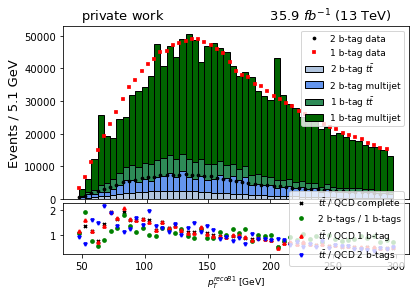

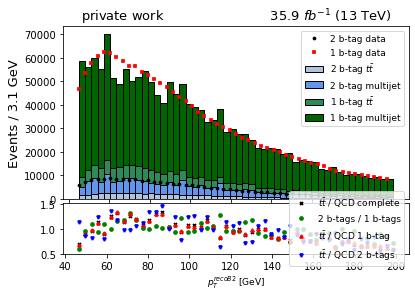

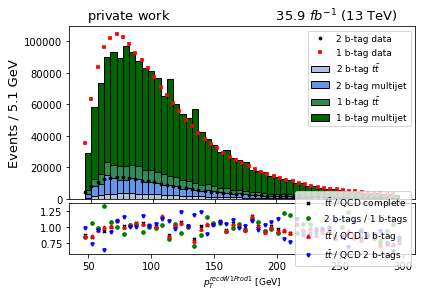

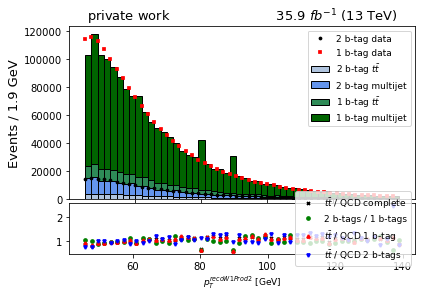

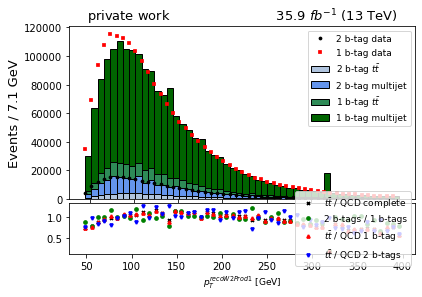

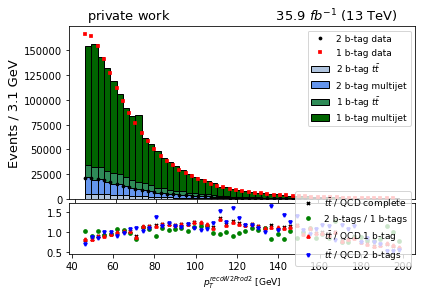

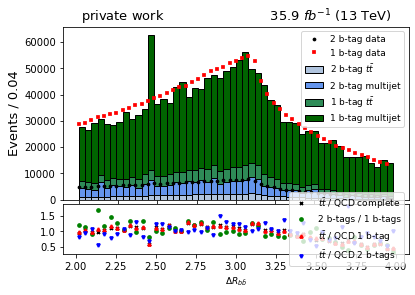

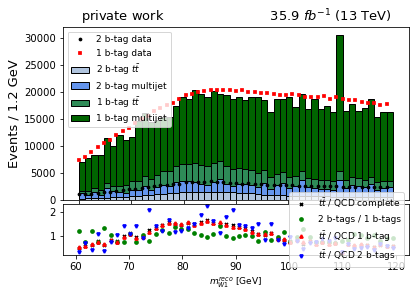

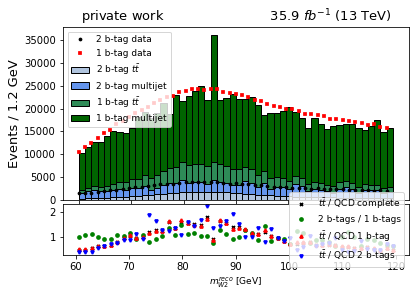

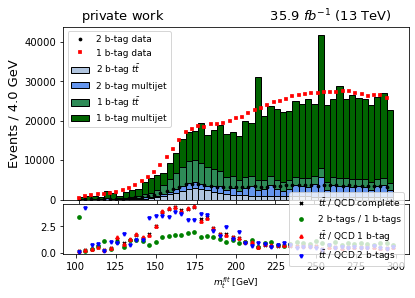

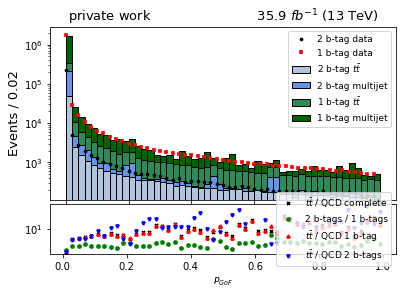

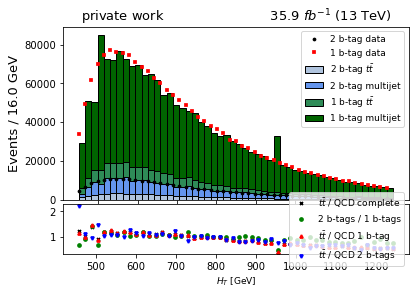

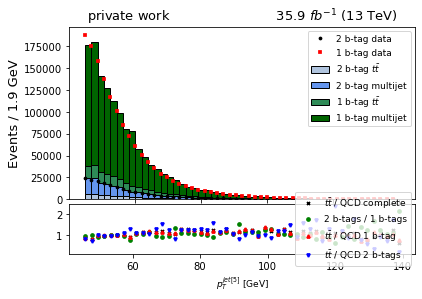

In [5]:
%matplotlib inline

# navigate to workspace folder and create new folder if it not existing already
os.chdir(workspace_folder)

if 'Input distributions' in os.listdir():
    pass
else:
    new_folder = os.mkdir('Input distributions')
os.chdir('Input distributions')


# compare number of events
print('Sum events CMS data: ' 
      + str(sum(CMS_2_btag[:, complete_feature_dictionary['weight.combinedWeight']])
            + sum(CMS_1_btag[:, complete_feature_dictionary['weight.combinedWeight']])))
print('Sum events MC simulation: ' 
      + str(np.around(MC_lum * (sum(TTbar[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']]) 
                                + sum(QCD[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']])),
                      decimals=0)))


# comparing CMS and MC simulated events for every chosen feature
for plot_number, feature in enumerate(features_of_interest):

    fig1 = plt.figure(plot_number)
    frame1 = fig1.add_axes((.15, .3, .8, .6))
    
    n_cms_1b, bins_cms_1b = \
        np.histogram(CMS_1_btag[:, complete_feature_dictionary[feature]],
                     bins=BIN_NUMBER,
                     range=range_dict_features_of_interest[feature])
    n_cms_2b, bins_cms_2b = \
        np.histogram(CMS_2_btag[:, complete_feature_dictionary[feature]],
                     bins=BIN_NUMBER,
                     range=range_dict_features_of_interest[feature])
    
    n, bins, patches = \
        frame1.hist([TTbar_2_btag[:, complete_feature_dictionary[feature]],
                     QCD_2_btag[:, complete_feature_dictionary[feature]],
                     TTbar_1_btag[:, complete_feature_dictionary[feature]],
                     QCD_1_btag[:, complete_feature_dictionary[feature]]],
                    weights=[TTbar_2_btag[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']] 
                             * MC_lum,
                             QCD_2_btag[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']] 
                             * MC_lum,
                             TTbar_1_btag[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']] 
                             * MC_lum,
                             QCD_1_btag[:, complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction']] 
                             * MC_lum],
                    bins=BIN_NUMBER,
                    stacked=True,
                    alpha=1,
                    edgecolor='k',
                    range=(range_dict_features_of_interest[feature]),
                    color=['lightsteelblue', 'cornflowerblue', 'seagreen', 'darkgreen'],
                    label= ['_nolegend_', '_nolegend_', '_nolegend_', '_nolegend_'])

    frame1.plot(bins_cms_1b[0:-1],
                n_cms_2b,
                color='k',
                marker='o',
                markersize=2,
                markeredgewidth=1.75,
                linestyle='')
    frame1.plot(bins_cms_1b[0:-1],
                n_cms_2b + n_cms_1b,
                color='r',
                marker='s',
                markersize=2,
                markeredgewidth=1.75,
                linestyle='')

    frame1.set_xticklabels([])  # Remove x-tic labels from the first frame

    x_label_string = x_label_dictionary[feature]
    y_label = np.around(((range_dict_features_of_interest[feature][1] - range_dict_features_of_interest[feature][0]) /
                         BIN_NUMBER), decimals=2)
    bin_shift_for_plotting = y_label / 2                                 # schifts residual plots in the

    if '[GeV]' in x_label_dictionary[feature]:             # GeV values on x axis need a unit
        y_label_string = r'Events / ' + str(y_label) + ' GeV'
    else:
        y_label_string = r'Events / ' + str(y_label)

    plt.title(r'private work'
              '                          '
              r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
    frame1.set_ylabel(y_label_string, fontsize=13)

    if feature == 'top.fitProb':                                          # here log scale, because > 95 % of data
        frame1.set_yscale('log')                                          # have P_GoF < 0.1

    frame1.legend({r'2 b-tag data': 'k',
                   r'1 b-tag data': 'r',
                   r'2 b-tag $t\bar{t}$': 'lightsteelblue',
                   r'2 b-tag multijet': 'cornflowerblue',
                   r'1 b-tag $t\bar{t}$': 'seagreen',
                   r'1 b-tag multijet': 'darkgreen'},
                  fontsize=9,
                  loc='best')

    frame2 = fig1.add_axes((.15, .11, .8, .175))

    # carefully addressing stacked histogram
    normalized_ttbar_complete = (n[2] - n[1] + n[0]) / sum(n[2] - n[1] + n[0])
    normalized_qcd_complete = (n[3] - n[2] + n[1] - n[0]) / sum(n[3] - n[2] + n[1] - n[0])

    normalized_1_btag = (n[3] - n[1]) / sum(n[3] - n[1])
    normalized_2_btag = n[1] / sum(n[1])

    normalized_ttbar_1_btag = (n[2] - n[1]) / sum(n[2] - n[1])
    normalized_ttbar_2_btag = n[0] / sum(n[0])

    normalized_qcd_1_tag = (n[3] - n[2]) / sum(n[3] - n[2])
    normalized_qcd_2_tag = (n[1] - n[0]) / sum(n[1] - n[0])

    normalized_ttbar_qcd_ratio_complete = normalized_ttbar_complete / normalized_qcd_complete
    normalized_ttbar_qcd_ratio_1_btag = normalized_ttbar_1_btag / normalized_qcd_1_tag
    normalized_ttbar_qcd_ratio_2_btag = normalized_ttbar_2_btag / normalized_qcd_2_tag
    normalized_2_btag_1_b_tag_ratio = normalized_2_btag / normalized_1_btag

    frame2.plot((bins + bin_shift_for_plotting)[0:-1],
                normalized_ttbar_qcd_ratio_complete,
                color='k',
                marker='x',
                markersize=3,
                markeredgewidth=1.75,
                linestyle='',
                label=r'$t\bar{t}$ / QCD complete')
    frame2.plot((bins + bin_shift_for_plotting)[0:-1],
                normalized_2_btag_1_b_tag_ratio,
                color='g',
                marker='o',
                markersize=3,
                markeredgewidth=1.75,
                linestyle='',
                label='2 b-tags / 1 b-tags')
    frame2.plot((bins + bin_shift_for_plotting)[0:-1],
                normalized_ttbar_qcd_ratio_1_btag,
                color='r',
                marker='^',
                markersize=3,
                markeredgewidth=1.75,
                linestyle='',
                label=r'$t\bar{t}$ / QCD 1 b-tag')
    frame2.plot((bins + bin_shift_for_plotting)[0:-1],
                normalized_ttbar_qcd_ratio_2_btag,
                color='b',
                marker='v',
                markersize=3,
                markeredgewidth=1.75,
                linestyle='',
                label=r'$t\bar{t}$ / QCD 2 b-tags')
    
    if feature == 'top.fitProb':                                          # here log scale, because > 95 % of data
        frame2.set_yscale('log') 
    frame2.legend(loc='right', fontsize=9)
    frame2.set_xlabel(x_label_string, fontsize=9)
    plt.savefig('Input_distribution_' + feature.replace('.', '_'))

Features interesting for the CWoLa approach should have the green dots in the ratio plots around the value 1,
while the other markers should differ from that. This would mean, that a separation in terms of signal ($t\bar{t}$) and background (QCD) is possible, while no discrimination for the number of b-tags per example is possible. So it might be possible to leave out the features which would accodriding to the just given explanation, but there is a reason to not leave them out. Referring to the $p_T$ values - to have all 6 jets in the training process is desired, since they can be confused by the kinematic fit.

## 2. 2 Normalization

The Normalization is done on $H_T$, the hadronic activity of an event with $H_T = \sum_{i=0}^{5}p_T^{jet[i]}$. Each value, if 
measured in $p_T$, is divided by the $H_T$ value, while the $H_T$ value itself is just divided by a factor of 5000.

In [6]:
# Normalizing input data
def normalize_on_ht(data_set, dictionary, feature_list):
    """This function takes a data set, a dictionary describing the properties of the data and a feature list
    and returns a normalization of values given in GeV in parts of HT.
    :param data_set: flattened numpy array
    :param dictionary: dictionary describing the properties of the values inside the data set
    :param feature_list: list of features which are normalized with respect to ht value
    :return returns the on ht normalized data set"""
    data_set_return = np.copy(data_set)
    for feature in feature_list:
        if feature != dictionary['top.fitProb'] and feature != dictionary['jet.HT']:
            data_set_return[:, dictionary[feature]] = data_set_return[:, dictionary[feature]] / data_set_return[:, dictionary['jet.HT']]
    data_set_return[:, dictionary['jet.HT']] = data_set_return[:, dictionary['jet.HT']] / 5000
    return data_set_return


# Normalizing arrays
CMS_1_btag = normalize_on_ht(CMS_1_btag, complete_feature_dictionary, training_features)
CMS_2_btag = normalize_on_ht(CMS_2_btag, complete_feature_dictionary, training_features)
CMS = normalize_on_ht(CMS, complete_feature_dictionary, training_features)

TTbar = normalize_on_ht(TTbar, complete_feature_dictionary, training_features)
TTbar_1_btag = normalize_on_ht(TTbar_1_btag, complete_feature_dictionary, training_features)
TTbar_2_btag = normalize_on_ht(TTbar_2_btag, complete_feature_dictionary, training_features)

QCD = normalize_on_ht(QCD, complete_feature_dictionary, training_features)
QCD_1_btag = normalize_on_ht(QCD_1_btag, complete_feature_dictionary, training_features)
QCD_2_btag = normalize_on_ht(QCD_2_btag, complete_feature_dictionary, training_features)

MC_Simulation_1_btag = normalize_on_ht(MC_Simulation_1_btag, complete_feature_dictionary, training_features)
MC_Simulation_2_btag = normalize_on_ht(MC_Simulation_2_btag, complete_feature_dictionary, training_features)

# 3. Buidling the Neural Network

Pease note, that this is a very basic implementation. The following code box can be replaced with a more sophisticated model, but keras gives an easy way to create a very basic model.

In [10]:
def create_model(optimizer,
                 nodes_list=(16, 32, 64, 32, 16, 8),
                 batch_normalization=True,
                 activation_function='selu',
                 kernel_initializer='glorot_normal',
                 bias_initializer='glorot_normal',
                 batch_size=1024,
                 loss='sparse_categorical_crossentropy',
                 metrics='accuracy'):

    """ creates a sequential model and writes a file with some of the training history
    :param nodes_list list of nodes for each dense layer, has to be the size of num_dense_layers
    :param batch_normalization if True batch normalization is used after each layer
    :param activation_function the used activation function for all but the last layer
    :param kernel_initializer kernel initializer, default 'he_uniform' like the one in the CWoLa paper
    :param bias_initializer bias initializer, default 'he_uniform' like the one in the CWoLa paper
    :param batch_size size of the used batches for training
    :param optimizer self build optimizer or adam with default values
    :param loss function of the model
    :param metrics tuple of metrics
    :return created model"""

    model = Sequential()
    for i in range(len(nodes_list)):
        model.add(Dense(nodes_list[i],
                        activation=activation_function,
                        kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer,
                        batch_size=batch_size))
        if batch_normalization and i != len(nodes_list) - 1:      # Never add batch normalization before softmax layer
            model.add(BatchNormalization())

    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

    return model


# specifying parameters for optimizer
LR = 1e-3
EPOCHS = 75 
DECAY = 0     # LR / EPOCHS
BETA_1 = 0.6
BETA_2 = 0.85
AMSGRAD = True

# Preparing k-fold cross validation
K_FOLDING = 5 # optimal value might be 10, but this needs a lot of time

adam = optimizers.Adam(lr=LR, decay=DECAY, beta_1=BETA_1, beta_2=BETA_2, amsgrad=AMSGRAD)

print('############################################################')
print('Using adam optimizer with the following parameters:\n' +
      'learning rate:', LR, '\n'
      'decay:', DECAY,  '\n'
      'beta1:', BETA_1, '\n'
      'beta2:', BETA_2, '\n'
      'amsgrad:', AMSGRAD)
print('############################################################', '\n')

############################################################
Using adam optimizer with the following parameters:
learning rate: 0.001 
decay: 1.3333333333333333e-05 
beta1: 0.6 
beta2: 0.85 
amsgrad: True
############################################################ 



In [8]:
# two useful functions for scaling weights and for implementing a k fold cross validataion with 
# respect to the weighting parameter of the samples
def scaling_weights(data, weight_position, number_normed_events=1e6):
    """ Normalizes input data, so weights of background and signal add up to the same value
    :param data data which has to be scaled
    :param weight_position position of the weight parameter
    :param number_normed_events re-weighting to 1 Million events per sample
    :return returns reweighted sample"""

    data_copy = np.copy(data)
    scaling_s = number_normed_events / sum(data[:, weight_position])

    data_copy[:, weight_position] = data[:, weight_position] * scaling_s

    return data_copy

def k_fold_cross_validation(k_folding, x_s, x_bg, weight_position):
    """Divides the data into k_folding equal weighted parts
     :param k_folding number of different parts
     :param x_s signal data
     :param x_bg background data
     :param weight_position -1 for MC and -2 for CMS data
     :return list of 2 times k_folding fractions"""
    np.random.shuffle(x_s)
    np.random.shuffle(x_bg)

    result = []

    j = 0
    k = 0

    j_index = 0
    k_index = 0

    x_s_sum = sum(x_s[:, weight_position])
    x_bg_sum = sum(x_bg[:, weight_position])

    for k_times in range(1, k_folding + 1):
        x_sample = []
        y_sample = []
        while j < k_times * 1 / k_folding * x_s_sum:
            x_sample.append(x_s[j_index, :])
            y_sample.append(1)
            j += x_s[j_index, weight_position]
            j_index += 1
        while k < k_times * 1 / k_folding * x_bg_sum:
            x_sample.append(x_bg[k_index, :])
            y_sample.append(0)
            k += x_bg[k_index, weight_position]
            k_index += 1

        randomize = np.arange(len(y_sample))
        np.random.shuffle(randomize)
        x_sample = np.array(x_sample)[randomize, :]
        y_sample = np.array(y_sample)[randomize]

        result.append([x_sample, y_sample])

    return result

# 4. Tests on MC simulated events

Before using the CWoLa approach on data, one has to verify if the Neural Network configuration along with 
the MC simulated samples to get an idea how good the classification might be. The code for the training is not optimzed
for runtime or for using gpu, but for good readability and to understand whats going on.

# 4.1  MC Simulation $t\bar{t}$ vs. QCD

First the training and evulation is done on MC simualted events. This will be the benchmark on which the CWoLa training will be measured in terms of AUC value.

In [11]:
# reweighting samples to match equal weighting
x_signal_normalized_reweighted = \
    scaling_weights(TTbar,
                    complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                    number_normed_events=1e6)

x_background_normalized_reweighted = \
    scaling_weights(QCD,
                    complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                    number_normed_events=1e6)


# define model output location over date string
date_string = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
os.chdir(workspace_folder)
os.mkdir('MC_Model_' + date_string)
os.chdir('MC_Model_' + date_string)
os.mkdir('Model_history')

# Take a self written k-folding algorithm, because
tenfold_split_data = k_fold_cross_validation(K_FOLDING,
                                             x_signal_normalized_reweighted,
                                             x_background_normalized_reweighted,
                                             complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'])


for i in range(K_FOLDING):
    
    start = time.time()
    
    print('Run k = ', i, '\n')
    X_tr = []
    y_tr = []
    for k_fold in range(K_FOLDING):
        if k_fold != i:
            for event, label in zip(tenfold_split_data[k_fold][0], tenfold_split_data[k_fold][1]):
                X_tr.append(event)
                y_tr.append(label)

    X_tr = np.array(X_tr)
    y_tr = np.array(y_tr)

    X_val = np.array(tenfold_split_data[i][0])
    y_val = np.array(tenfold_split_data[i][1])

    file_path_val_loss = 'Run_' + str(i) + '_weights_best_val_loss.h5'
    file_path_val_accuracy = 'Run_' + str(i) + '_weights_best_val_accuracy.h5'
    
    classifier = create_model(adam,
                          nodes_list=(16, 32, 64, 32, 16, 8),
                          batch_normalization=True,
                          activation_function='selu',
                          kernel_initializer='glorot_normal',
                          bias_initializer='glorot_normal',
                          batch_size=1024,
                          loss='sparse_categorical_crossentropy',
                          metrics='accuracy')
    
    # checking for lowest val loss and accuracy
    checkpoint_val_loss = \
        ModelCheckpoint(file_path_val_loss,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        mode='min')

    checkpoint_val_accuracy = \
        ModelCheckpoint(file_path_val_accuracy,
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        mode='max')

    callbacks_list = [checkpoint_val_loss, checkpoint_val_accuracy]
    model_history = classifier.fit(X_tr[:, np.array([complete_feature_dictionary[f] 
                                                     for f in training_features])],
                                   y_tr,
                                   sample_weight=X_tr[:, complete_feature_dictionary[
                                       'combinedWeight_and_trigger_efficiency_correction']],
                                   epochs=EPOCHS,
                                   verbose=2,
                                   validation_data=(X_val[:, np.array([complete_feature_dictionary[f] 
                                                                       for f in training_features])],
                                                    y_val,
                                                    X_val[:, complete_feature_dictionary[
                                                        'combinedWeight_and_trigger_efficiency_correction']]),
                                   callbacks=callbacks_list,
                                   shuffle=True)

    model_json = classifier.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    classifier.save_weights('after_last_epoch.h5')
    
    del classifier

    # Plot training & validation accuracy values
    plt.figure(i)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.savefig('Model_history/Model accuracy_' + str(i))
    plt.close(i)

    # Plot training & validation loss values
    plt.figure(i + K_FOLDING)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.savefig('Model_history/Model loss_' + str(i))
    plt.close(i + K_FOLDING)
    
    one_k_fold = time.time() - start
    print('elapsed time for k = ' + str(i) + ': ' + hms_string(one_k_fold))
    

# sometimes there are issues with the garbage collector 
del x_signal_normalized_reweighted
del x_background_normalized_reweighted
del tenfold_split_data
del classifier

Run k =  0 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 702022 samples, validate on 175801 samples
Epoch 1/75

Epoch 00001: val_loss improved from inf to 1.34097, saving model to Run_0_weights_best_val_loss.h5

Epoch 00001: val_accuracy improved from -inf to 0.68104, saving model to Run_0_weights_best_val_accuracy.h5
702022/702022 - 66s - loss: 1.3834 - accuracy: 0.6705 - val_loss: 1.3410 - val_accuracy: 0.6810
Epoch 2/75

Epoch 00002: val_loss improved from 1.34097 to 1.33613, saving model to Run_0_weights_best_val_loss.h5

Epoch 00002: val_accuracy improved from 0.68104 to 0.68914, saving model to Run_0_weights_best_val_accuracy.h5
702022/702022 - 58s - loss: 1.3708 - accuracy: 0.6754 - val_loss: 1.3361 - val_accuracy: 0.6891
Epoch 3/75

Epoch 00003: val_loss improved from 1.33613 to 1.33448, saving model to Run_0_weights_best_val_loss.h5

Epoch 00003: val_accuracy improved from 0.68914 to 0.69344, saving model to Run_0_weights_best_val_accuracy.h5
702022/702022 - 53s


Epoch 00032: val_loss did not improve from 1.32847

Epoch 00032: val_accuracy did not improve from 0.70270
702022/702022 - 52s - loss: 1.3557 - accuracy: 0.6849 - val_loss: 1.3286 - val_accuracy: 0.6969
Epoch 33/75

Epoch 00033: val_loss improved from 1.32847 to 1.32845, saving model to Run_0_weights_best_val_loss.h5

Epoch 00033: val_accuracy did not improve from 0.70270
702022/702022 - 56s - loss: 1.3489 - accuracy: 0.6855 - val_loss: 1.3284 - val_accuracy: 0.6987
Epoch 34/75

Epoch 00034: val_loss improved from 1.32845 to 1.32838, saving model to Run_0_weights_best_val_loss.h5

Epoch 00034: val_accuracy did not improve from 0.70270
702022/702022 - 61s - loss: 1.3506 - accuracy: 0.6852 - val_loss: 1.3284 - val_accuracy: 0.6967
Epoch 35/75

Epoch 00035: val_loss improved from 1.32838 to 1.32828, saving model to Run_0_weights_best_val_loss.h5

Epoch 00035: val_accuracy did not improve from 0.70270
702022/702022 - 56s - loss: 1.3468 - accuracy: 0.6855 - val_loss: 1.3283 - val_accuracy:

Epoch 68/75

Epoch 00068: val_loss did not improve from 1.32707

Epoch 00068: val_accuracy did not improve from 0.70270
702022/702022 - 54s - loss: 1.3485 - accuracy: 0.6862 - val_loss: 1.3273 - val_accuracy: 0.6981
Epoch 69/75

Epoch 00069: val_loss did not improve from 1.32707

Epoch 00069: val_accuracy did not improve from 0.70270
702022/702022 - 53s - loss: 1.3494 - accuracy: 0.6863 - val_loss: 1.3271 - val_accuracy: 0.6989
Epoch 70/75

Epoch 00070: val_loss did not improve from 1.32707

Epoch 00070: val_accuracy did not improve from 0.70270
702022/702022 - 53s - loss: 1.3494 - accuracy: 0.6863 - val_loss: 1.3274 - val_accuracy: 0.7012
Epoch 71/75

Epoch 00071: val_loss improved from 1.32707 to 1.32703, saving model to Run_0_weights_best_val_loss.h5

Epoch 00071: val_accuracy did not improve from 0.70270
702022/702022 - 53s - loss: 1.3472 - accuracy: 0.6862 - val_loss: 1.3270 - val_accuracy: 0.6970
Epoch 72/75

Epoch 00072: val_loss did not improve from 1.32703

Epoch 00072: val_ac

Epoch 25/75

Epoch 00025: val_loss did not improve from 1.38642

Epoch 00025: val_accuracy did not improve from 0.67859
702981/702981 - 59s - loss: 1.3695 - accuracy: 0.6620 - val_loss: 1.3867 - val_accuracy: 0.6783
Epoch 26/75

Epoch 00026: val_loss did not improve from 1.38642

Epoch 00026: val_accuracy improved from 0.67859 to 0.67941, saving model to Run_1_weights_best_val_accuracy.h5
702981/702981 - 53s - loss: 1.3688 - accuracy: 0.6629 - val_loss: 1.3877 - val_accuracy: 0.6794
Epoch 27/75

Epoch 00027: val_loss improved from 1.38642 to 1.38542, saving model to Run_1_weights_best_val_loss.h5

Epoch 00027: val_accuracy did not improve from 0.67941
702981/702981 - 53s - loss: 1.3696 - accuracy: 0.6625 - val_loss: 1.3854 - val_accuracy: 0.6716
Epoch 28/75

Epoch 00028: val_loss improved from 1.38542 to 1.38528, saving model to Run_1_weights_best_val_loss.h5

Epoch 00028: val_accuracy did not improve from 0.67941
702981/702981 - 53s - loss: 1.3691 - accuracy: 0.6617 - val_loss: 1.3853

Epoch 59/75

Epoch 00059: val_loss did not improve from 1.37875

Epoch 00059: val_accuracy did not improve from 0.68413
702981/702981 - 53s - loss: 1.3651 - accuracy: 0.6660 - val_loss: 1.3793 - val_accuracy: 0.6812
Epoch 60/75

Epoch 00060: val_loss did not improve from 1.37875

Epoch 00060: val_accuracy did not improve from 0.68413
702981/702981 - 53s - loss: 1.3658 - accuracy: 0.6661 - val_loss: 1.3794 - val_accuracy: 0.6781
Epoch 61/75

Epoch 00061: val_loss did not improve from 1.37875

Epoch 00061: val_accuracy did not improve from 0.68413
702981/702981 - 53s - loss: 1.3632 - accuracy: 0.6658 - val_loss: 1.3791 - val_accuracy: 0.6817
Epoch 62/75

Epoch 00062: val_loss did not improve from 1.37875

Epoch 00062: val_accuracy did not improve from 0.68413
702981/702981 - 60s - loss: 1.3639 - accuracy: 0.6671 - val_loss: 1.3791 - val_accuracy: 0.6817
Epoch 63/75

Epoch 00063: val_loss did not improve from 1.37875

Epoch 00063: val_accuracy improved from 0.68413 to 0.68485, saving mode

Epoch 14/75

Epoch 00014: val_loss improved from 1.36907 to 1.36797, saving model to Run_2_weights_best_val_loss.h5

Epoch 00014: val_accuracy improved from 0.66761 to 0.66797, saving model to Run_2_weights_best_val_accuracy.h5
703198/703198 - 61s - loss: 1.3849 - accuracy: 0.6528 - val_loss: 1.3680 - val_accuracy: 0.6680
Epoch 15/75

Epoch 00015: val_loss improved from 1.36797 to 1.36700, saving model to Run_2_weights_best_val_loss.h5

Epoch 00015: val_accuracy did not improve from 0.66797
703198/703198 - 59s - loss: 1.3824 - accuracy: 0.6528 - val_loss: 1.3670 - val_accuracy: 0.6677
Epoch 16/75

Epoch 00016: val_loss improved from 1.36700 to 1.36607, saving model to Run_2_weights_best_val_loss.h5

Epoch 00016: val_accuracy improved from 0.66797 to 0.67131, saving model to Run_2_weights_best_val_accuracy.h5
703198/703198 - 53s - loss: 1.3820 - accuracy: 0.6546 - val_loss: 1.3661 - val_accuracy: 0.6713
Epoch 17/75

Epoch 00017: val_loss did not improve from 1.36607

Epoch 00017: val_ac


Epoch 00045: val_loss did not improve from 1.35718

Epoch 00045: val_accuracy did not improve from 0.68786
703198/703198 - 53s - loss: 1.3739 - accuracy: 0.6647 - val_loss: 1.3577 - val_accuracy: 0.6828
Epoch 46/75

Epoch 00046: val_loss improved from 1.35718 to 1.35699, saving model to Run_2_weights_best_val_loss.h5

Epoch 00046: val_accuracy did not improve from 0.68786
703198/703198 - 53s - loss: 1.3720 - accuracy: 0.6650 - val_loss: 1.3570 - val_accuracy: 0.6823
Epoch 47/75

Epoch 00047: val_loss improved from 1.35699 to 1.35648, saving model to Run_2_weights_best_val_loss.h5

Epoch 00047: val_accuracy did not improve from 0.68786
703198/703198 - 53s - loss: 1.3733 - accuracy: 0.6652 - val_loss: 1.3565 - val_accuracy: 0.6804
Epoch 48/75

Epoch 00048: val_loss did not improve from 1.35648

Epoch 00048: val_accuracy did not improve from 0.68786
703198/703198 - 52s - loss: 1.3738 - accuracy: 0.6651 - val_loss: 1.3571 - val_accuracy: 0.6840
Epoch 49/75

Epoch 00049: val_loss did not i

Epoch 4/75

Epoch 00004: val_loss improved from 1.40317 to 1.39820, saving model to Run_3_weights_best_val_loss.h5

Epoch 00004: val_accuracy improved from 0.59060 to 0.59980, saving model to Run_3_weights_best_val_accuracy.h5
702028/702028 - 53s - loss: 1.4406 - accuracy: 0.5876 - val_loss: 1.3982 - val_accuracy: 0.5998
Epoch 5/75

Epoch 00005: val_loss improved from 1.39820 to 1.39547, saving model to Run_3_weights_best_val_loss.h5

Epoch 00005: val_accuracy improved from 0.59980 to 0.60141, saving model to Run_3_weights_best_val_accuracy.h5
702028/702028 - 53s - loss: 1.4305 - accuracy: 0.5901 - val_loss: 1.3955 - val_accuracy: 0.6014
Epoch 6/75

Epoch 00006: val_loss improved from 1.39547 to 1.39540, saving model to Run_3_weights_best_val_loss.h5

Epoch 00006: val_accuracy did not improve from 0.60141
702028/702028 - 54s - loss: 1.4364 - accuracy: 0.5922 - val_loss: 1.3954 - val_accuracy: 0.5996
Epoch 7/75

Epoch 00007: val_loss improved from 1.39540 to 1.39164, saving model to Run

Epoch 35/75

Epoch 00035: val_loss did not improve from 1.37140

Epoch 00035: val_accuracy did not improve from 0.63906
702028/702028 - 53s - loss: 1.4121 - accuracy: 0.6204 - val_loss: 1.3726 - val_accuracy: 0.6289
Epoch 36/75

Epoch 00036: val_loss did not improve from 1.37140

Epoch 00036: val_accuracy did not improve from 0.63906
702028/702028 - 53s - loss: 1.4084 - accuracy: 0.6209 - val_loss: 1.3726 - val_accuracy: 0.6273
Epoch 37/75

Epoch 00037: val_loss improved from 1.37140 to 1.37134, saving model to Run_3_weights_best_val_loss.h5

Epoch 00037: val_accuracy did not improve from 0.63906
702028/702028 - 53s - loss: 1.4030 - accuracy: 0.6213 - val_loss: 1.3713 - val_accuracy: 0.6344
Epoch 38/75

Epoch 00038: val_loss improved from 1.37134 to 1.37130, saving model to Run_3_weights_best_val_loss.h5

Epoch 00038: val_accuracy did not improve from 0.63906
702028/702028 - 53s - loss: 1.4060 - accuracy: 0.6224 - val_loss: 1.3713 - val_accuracy: 0.6337
Epoch 39/75

Epoch 00039: val_lo

Epoch 69/75

Epoch 00069: val_loss did not improve from 1.36339

Epoch 00069: val_accuracy did not improve from 0.64604
702028/702028 - 53s - loss: 1.3987 - accuracy: 0.6307 - val_loss: 1.3635 - val_accuracy: 0.6449
Epoch 70/75

Epoch 00070: val_loss did not improve from 1.36339

Epoch 00070: val_accuracy did not improve from 0.64604
702028/702028 - 53s - loss: 1.3993 - accuracy: 0.6311 - val_loss: 1.3643 - val_accuracy: 0.6430
Epoch 71/75

Epoch 00071: val_loss improved from 1.36339 to 1.36316, saving model to Run_3_weights_best_val_loss.h5

Epoch 00071: val_accuracy did not improve from 0.64604
702028/702028 - 53s - loss: 1.4049 - accuracy: 0.6305 - val_loss: 1.3632 - val_accuracy: 0.6438
Epoch 72/75

Epoch 00072: val_loss improved from 1.36316 to 1.36244, saving model to Run_3_weights_best_val_loss.h5

Epoch 00072: val_accuracy improved from 0.64604 to 0.64655, saving model to Run_3_weights_best_val_accuracy.h5
702028/702028 - 53s - loss: 1.4023 - accuracy: 0.6311 - val_loss: 1.3624

Epoch 24/75

Epoch 00024: val_loss did not improve from 1.37488

Epoch 00024: val_accuracy did not improve from 0.63416
701063/701063 - 53s - loss: 1.3935 - accuracy: 0.6269 - val_loss: 1.3760 - val_accuracy: 0.6302
Epoch 25/75

Epoch 00025: val_loss improved from 1.37488 to 1.37351, saving model to Run_4_weights_best_val_loss.h5

Epoch 00025: val_accuracy improved from 0.63416 to 0.63648, saving model to Run_4_weights_best_val_accuracy.h5
701063/701063 - 53s - loss: 1.3968 - accuracy: 0.6269 - val_loss: 1.3735 - val_accuracy: 0.6365
Epoch 26/75

Epoch 00026: val_loss did not improve from 1.37351

Epoch 00026: val_accuracy improved from 0.63648 to 0.63768, saving model to Run_4_weights_best_val_accuracy.h5
701063/701063 - 53s - loss: 1.3971 - accuracy: 0.6274 - val_loss: 1.3736 - val_accuracy: 0.6377
Epoch 27/75

Epoch 00027: val_loss did not improve from 1.37351

Epoch 00027: val_accuracy did not improve from 0.63768
701063/701063 - 53s - loss: 1.3960 - accuracy: 0.6288 - val_loss: 1.

701063/701063 - 54s - loss: 1.3899 - accuracy: 0.6385 - val_loss: 1.3656 - val_accuracy: 0.6506
Epoch 58/75

Epoch 00058: val_loss improved from 1.36559 to 1.36367, saving model to Run_4_weights_best_val_loss.h5

Epoch 00058: val_accuracy improved from 0.65059 to 0.65509, saving model to Run_4_weights_best_val_accuracy.h5
701063/701063 - 53s - loss: 1.3867 - accuracy: 0.6396 - val_loss: 1.3637 - val_accuracy: 0.6551
Epoch 59/75

Epoch 00059: val_loss did not improve from 1.36367

Epoch 00059: val_accuracy did not improve from 0.65509
701063/701063 - 53s - loss: 1.3873 - accuracy: 0.6395 - val_loss: 1.3658 - val_accuracy: 0.6481
Epoch 60/75

Epoch 00060: val_loss did not improve from 1.36367

Epoch 00060: val_accuracy did not improve from 0.65509
701063/701063 - 53s - loss: 1.3891 - accuracy: 0.6400 - val_loss: 1.3644 - val_accuracy: 0.6515
Epoch 61/75

Epoch 00061: val_loss did not improve from 1.36367

Epoch 00061: val_accuracy did not improve from 0.65509
701063/701063 - 53s - loss: 

NameError: name 'classifier' is not defined

### AUC value
Now The AUC value with the standard deviation derived from the k-fold cross validation outcomes is calculated.
    In this case, the AUC value is not calculated for a validation set, but for the whole data set. This is in fact not "good practice", but we later want to compare this result to the CWoLa trained classifier where only data is used t for the training process. Therefore one can use the whole data set to compare results, especially regarding unbalanced weights of the MC simulated QCD events, which might mess up the evaulation greatly if there aren't many other events to balance results.

Loaded model 0 from disk
Loaded model 1 from disk
Loaded model 2 from disk
Loaded model 3 from disk
Loaded model 4 from disk


E:\Anacdonda\envs\tensorflow_keras\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
E:\Anacdonda\envs\tensorflow_keras\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
E:\Anacdonda\envs\tensorflow_keras\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


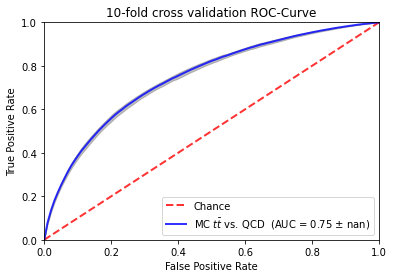

In [12]:
X = np.concatenate([TTbar, QCD])
y = np.concatenate([np.ones(len(TTbar)), np.zeros(len(QCD))])

tprs = []
tprs_btag = []
aucs = []
aucs_btag = []
mean_fpr = np.linspace(0, 1, 100)
mean_fpr_btag = np.linspace(0, 1, 100)

# load json and create model
os.chdir(workspace_folder)
os.chdir('MC_Model_' + date_string)
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into model
for i in range(K_FOLDING):
    loaded_model.load_weights('Run_' + str(i) + '_weights_best_val_loss.h5')
    print('Loaded model ' + str(i) + ' from disk')

    predictions = loaded_model.predict(X[:, np.array([complete_feature_dictionary[f] 
                                                      for f in training_features])])
    fpr, tpr, thresholds = roc_curve(y,
                                     predictions[:, 1],
                                     sample_weight=X[:, complete_feature_dictionary[
                                         'combinedWeight_and_trigger_efficiency_correction']])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

plt.figure(0)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)



mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc_val = auc(mean_fpr, mean_tpr)
std_auc_val = np.std(aucs_btag)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'MC $t\bar{t}$ vs. QCD  (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),
         lw=2, alpha=.8)


std_tpr_val = np.std(tprs, axis=0)
tprs_upper_val = np.minimum(mean_tpr + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr - std_tpr_val, 0)
plt.fill_between(mean_fpr, tprs_lower_val, tprs_upper_val, color='grey', alpha=.5,
                 label='')


plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-fold cross validation ROC-Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve')

del X
del y

# 4.2  MC Simulation $t\bar{t}$ vs. QCD CWoLa

The data is now separated according to the next figure. The estimated signal fractions are of 10.3% for 1 b-tag samples and 26.9% for 2 b-tag samples. For pairs of fractions $f_1$ and $f_2$ $\in$ [0.0, 0.40] in steps of 0.25 a training is done and the AUC value is calculated.

![title](img/MC_CWoLa_separation.png)

In [13]:
# create training data for mixed samples using different fractions
def creating_training_data(signal_data,
                           background_data,
                           f1,
                           f2,
                           number_of_events,
                           lum=MC_lum):
    """ Takes signal and background data and creates training, test and validation samples. The ratio between training
    validation and signal samples is always 8:1:1.
    :param signal_data data with signal events
    :param background_data data with background events
    :param f1 signal fraction of training signal sample, has to be greater than f2
    :param f2 signal fraction of training background sample
    :param number_of_events number of events per returned sample
    :param lum luminosity
    :return returns training data x,y with fractions"""

    shuffle_signal = np.arange(len(signal_data))
    shuffle_background = np.arange(len(background_data))

    np.random.shuffle(shuffle_signal)
    np.random.shuffle(shuffle_background)

    signal_data = signal_data[shuffle_signal]
    background_data = background_data[shuffle_background]

    train_x = []
    train_y = []

    signal_index = 0
    background_index = 0

    # Sample 1
    sample_one_counter = 0

    while sample_one_counter < f1 * number_of_events:
        train_x.append(signal_data[signal_index, :])
        train_y.append(1)
        signal_index += 1
        sample_one_counter += signal_data[signal_index, -1] * lum

    while sample_one_counter < number_of_events:
        train_x.append(background_data[background_index, :])
        train_y.append(1)
        background_index += 1
        sample_one_counter += background_data[background_index, -1] * lum

    # Sample 2
    sample_two_counter = 0

    while sample_two_counter < f2 * number_of_events:
        train_x.append(signal_data[signal_index, :])
        train_y.append(0)
        signal_index += 1
        sample_two_counter += signal_data[signal_index, -1] * lum

    while sample_two_counter < number_of_events:
        train_x.append(background_data[background_index, :])
        train_y.append(0)
        background_index += 1
        sample_two_counter += background_data[background_index, -1] * lum

    # shuffle again. just to make sure there will be no order
    shuffle_array_training = np.arange(np.size(train_x, axis=0))
    np.random.shuffle(shuffle_array_training)

    shuffled_array_training_x = np.array(train_x)[shuffle_array_training]
    shuffled_array_training_y = np.array(train_y)[shuffle_array_training]

    # print('Weight sum of the training data = ', sum(np.array(shuffled_array_training_x)[:, -1]) * lum)

    return shuffled_array_training_x, shuffled_array_training_y


f1 = 0.4, f2 = 0.4
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 10998 samples, validate on 877823 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 2.03353, saving model to Run_0_0_weights_best_val_loss.h5
10998/10998 - 36s - loss: 2.2701 - accuracy: 0.4961 - val_loss: 2.0335 - val_accuracy: 0.5309
Epoch 2/10

Epoch 00002: val_loss did not improve from 2.03353
10998/10998 - 30s - loss: 2.2003 - accuracy: 0.4964 - val_loss: 2.1123 - val_accuracy: 0.5504
Epoch 3/10

Epoch 00003: val_loss did not improve from 2.03353
10998/10998 - 30s - loss: 2.0975 - accuracy: 0.4940 - val_loss: 2.0625 - val_accuracy: 0.5462
Epoch 4/10

Epoch 00004: val_loss did not improve from 2.03353
10998/10998 - 30s - loss: 2.0766 - accuracy: 0.4955 - val_loss: 2.0338 - val_accuracy: 0.5450
Epoch 5/10

Epoch 00005: val_loss improved from 2.03353 to 2.01227, saving model to Run_0_0_weights_best_val_loss.h5
10998/10998 - 30s - loss: 2.0418 - accuracy: 0.4993 - val_loss: 2.0123 - val_accuracy

Epoch 10/10

Epoch 00010: val_loss did not improve from 1.70220
8176/8176 - 30s - loss: 1.8220 - accuracy: 0.5022 - val_loss: 1.8639 - val_accuracy: 0.5932
f1 = 0.4, f2 = 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 14191 samples, validate on 877823 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 2.77946, saving model to Run_0_4_weights_best_val_loss.h5
14191/14191 - 32s - loss: 1.8974 - accuracy: 0.5410 - val_loss: 2.7795 - val_accuracy: 0.4604
Epoch 2/10

Epoch 00002: val_loss improved from 2.77946 to 2.67933, saving model to Run_0_4_weights_best_val_loss.h5
14191/14191 - 30s - loss: 1.8137 - accuracy: 0.5437 - val_loss: 2.6793 - val_accuracy: 0.4324
Epoch 3/10

Epoch 00003: val_loss improved from 2.67933 to 2.67249, saving model to Run_0_4_weights_best_val_loss.h5
14191/14191 - 30s - loss: 1.8234 - accuracy: 0.5446 - val_loss: 2.6725 - val_accuracy: 0.4300
Epoch 4/10

Epoch 00004: val_loss improved from 2.67249 to 2.63383, saving model to Run_0_4_weigh

f1 = 0.3, f2 = 0
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 13899 samples, validate on 877823 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 2.57960, saving model to Run_1_4_weights_best_val_loss.h5
13899/13899 - 37s - loss: 2.3114 - accuracy: 0.5098 - val_loss: 2.5796 - val_accuracy: 0.4802
Epoch 2/10

Epoch 00002: val_loss did not improve from 2.57960
13899/13899 - 36s - loss: 2.3047 - accuracy: 0.5008 - val_loss: 2.9176 - val_accuracy: 0.4961
Epoch 3/10

Epoch 00003: val_loss did not improve from 2.57960
13899/13899 - 36s - loss: 2.2355 - accuracy: 0.5032 - val_loss: 2.8930 - val_accuracy: 0.5000
Epoch 4/10

Epoch 00004: val_loss did not improve from 2.57960
13899/13899 - 34s - loss: 2.1167 - accuracy: 0.5041 - val_loss: 2.8534 - val_accuracy: 0.4963
Epoch 5/10

Epoch 00005: val_loss did not improve from 2.57960
13899/13899 - 31s - loss: 2.1729 - accuracy: 0.5054 - val_loss: 2.8295 - val_accuracy: 0.4918
Epoch 6/10

Epoch 00006: val_loss did not impro

Epoch 3/10

Epoch 00003: val_loss did not improve from 1.89855
13734/13734 - 31s - loss: 1.4552 - accuracy: 0.4960 - val_loss: 1.9134 - val_accuracy: 0.6044
Epoch 4/10

Epoch 00004: val_loss improved from 1.89855 to 1.89026, saving model to Run_3_3_weights_best_val_loss.h5
13734/13734 - 31s - loss: 1.4154 - accuracy: 0.5015 - val_loss: 1.8903 - val_accuracy: 0.6033
Epoch 5/10

Epoch 00005: val_loss improved from 1.89026 to 1.85042, saving model to Run_3_3_weights_best_val_loss.h5
13734/13734 - 30s - loss: 1.3805 - accuracy: 0.4956 - val_loss: 1.8504 - val_accuracy: 0.6089
Epoch 6/10

Epoch 00006: val_loss improved from 1.85042 to 1.83328, saving model to Run_3_3_weights_best_val_loss.h5
13734/13734 - 31s - loss: 1.3978 - accuracy: 0.4967 - val_loss: 1.8333 - val_accuracy: 0.6076
Epoch 7/10

Epoch 00007: val_loss improved from 1.83328 to 1.82625, saving model to Run_3_3_weights_best_val_loss.h5
13734/13734 - 30s - loss: 1.3616 - accuracy: 0.5004 - val_loss: 1.8262 - val_accuracy: 0.6061

E:\Anacdonda\envs\tensorflow_keras\lib\site-packages\ipykernel_launcher.py:107: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


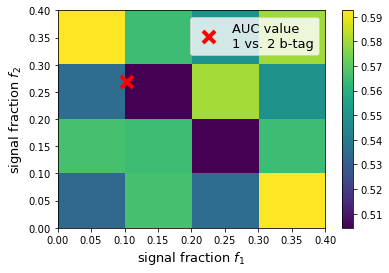

In [14]:
# Starting AUC 2D calculation
os.chdir(workspace_folder)

if 'MC_2D_f1_f2_combinations' in os.listdir():
    pass
else:
    new_folder = os.mkdir('MC_2D_f1_f2_combinations')
os.chdir('MC_2D_f1_f2_combinations')

x_signal_normalized_reweighted = \
    scaling_weights(MC_Simulation_2_btag,
                    complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                    number_normed_events=1e6)

x_background_normalized_reweighted = \
    scaling_weights(MC_Simulation_1_btag,
                    complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                    number_normed_events=1e6)

x_val = np.concatenate([scaling_weights(TTbar,
                                        complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                                        number_normed_events=1e6), 
                        scaling_weights(QCD,
                                        complete_feature_dictionary['combinedWeight_and_trigger_efficiency_correction'],
                                        number_normed_events=1e6)])
y_val = np.concatenate([np.ones(len(TTbar)), np.zeros(len(QCD))])


N = 400000
# f = [0.4, 0.375, 0.35, 0.325, 0.3, 0.275, 0.25, 0.225, 0.2, 0.175, 0.15, 0.125, 0.1, 0.075, 0.05, 0.025, 0]
f = [0.4, 0.3, 0.2, 0.1, 0]

auc_array = np.zeros((len(f), len(f)))
for i, f1 in enumerate(f):
    for k, f2 in enumerate(f):
        if f2 > f1:
            continue
        else:
            print('f1 = ' + str(f1) + ', f2 = ' + str(f2))

            X_tr, y_tr = creating_training_data(x_signal_normalized_reweighted,
                                                x_background_normalized_reweighted,
                                                f1,
                                                f2,
                                                N,
                                                MC_lum)

            classifier = create_model(adam,
                                      nodes_list=(16, 32, 64, 32, 16, 8),
                                      batch_normalization=True,
                                      activation_function='selu',
                                      kernel_initializer='glorot_normal',
                                      bias_initializer='glorot_normal',
                                      batch_size=1024,
                                      loss='sparse_categorical_crossentropy',
                                      metrics='accuracy')

            filepath_val_loss = 'Run_' + str(i) + '_' + str(k) + '_weights_best_val_loss.h5'
            # filepath_val_accuracy = 'Run_' + str(i) + '_' + str(k) + '_weights_best_val_accuracy.h5'

            checkpoint_val_loss = \
                ModelCheckpoint(filepath_val_loss, monitor='val_loss', verbose=1, save_weights_only=True,
                                save_best_only=True, mode='min')

            model_history = classifier.fit(X_tr[:, np.array([complete_feature_dictionary[f] 
                                                             for f in training_features])],
                                           y_tr,
                                           sample_weight=X_tr[:, complete_feature_dictionary[
                                                                 'combinedWeight_and_trigger_efficiency_correction']],
                                           epochs=10,
                                           verbose=2,
                                           validation_data=(x_val[:, np.array([complete_feature_dictionary[f] 
                                                                              for f in training_features])],
                                                            y_val,
                                                            x_val[:, complete_feature_dictionary[
                                                                'combinedWeight_and_trigger_efficiency_correction']]),
                                           callbacks=[checkpoint_val_loss],
                                           shuffle=True)

            # ROC Curves
            classifier.load_weights('Run_' + str(i) + '_' + str(k) + '_weights_best_val_loss.h5')
            predictions = classifier.predict(x_val[:, np.array([complete_feature_dictionary[f] 
                                                                       for f in training_features])])
            fpr, tpr, thresholds = roc_curve(y_val,
                                             predictions[:, 1],
                                             sample_weight=x_val[:, complete_feature_dictionary[
                                                                    'combinedWeight_and_trigger_efficiency_correction']])

            roc_auc = auc(fpr, tpr)
            if roc_auc > 0.5:
                auc_array[i, k] = roc_auc
                auc_array[k, i] = roc_auc
            else:
                auc_array[i, k] = 1 - roc_auc
                auc_array[k, i] = 1 - roc_auc

            backend.clear_session()
            del classifier

print(auc_array)
np.save('auc_array_N_' + str(N), np.array(auc_array))

x, y = f, f

label_1vs2_btag = 'AUC value\n1 vs. 2 b-tag'
xx, yy = np.meshgrid(f, f)
h = plt.pcolormesh(x, y, auc_array)
plt.plot(0.103, 0.269, 'xr', markersize=12, mew=4)
plt.xlabel('signal fraction $f_1$', fontsize=13)
plt.ylabel('signal fraction $f_2$', fontsize=13)
plt.legend({label_1vs2_btag: 'rx'}, fontsize=13)
plt.colorbar()
plt.savefig('AUC_2d')

# 5. CWoLa on data

## 5.1 Training and evaluation

Now the time has come to use this approach on data and evaluate on MC simualted events and data simultaneously. 
The modified procedure is shown in teh following figure.

![title](img/CMS_data_CWoLa_separation.png)

In [15]:
# preparing data for training
x_signal_normed_reweighted = \
    scaling_weights(CMS_2_btag,
                    complete_feature_dictionary['weight.combinedWeight'],
                    number_normed_events=1e6)

x_background_normed_reweighted = \
    scaling_weights(CMS_1_btag,
                    complete_feature_dictionary['weight.combinedWeight'],
                    number_normed_events=1e6)


# define model output location over date string
try:
    os.mkdir('CMS_Model_' + date_string)
except:
    pass
os.chdir('CMS_Model_' + date_string)
os.mkdir('Model_history')


tenfold_split_data = k_fold_cross_validation(K_FOLDING,
                                             x_signal_normed_reweighted,
                                             x_background_normed_reweighted,
                                             complete_feature_dictionary['weight.combinedWeight'])


for i in range(K_FOLDING):
    print('Run k = ', i, '\n')
    
    start = time.time()
    
    classifier = create_model(adam,
                              nodes_list=(16, 32, 64, 32, 16, 8),
                              batch_normalization=True,
                              activation_function='selu',
                              kernel_initializer='glorot_normal',
                              bias_initializer='glorot_normal',
                              batch_size=1024,
                              loss='sparse_categorical_crossentropy',
                              metrics='accuracy')
    X_tr = []
    y_tr = []
    for k_fold in range(K_FOLDING):
        if k_fold != i:
            for event, label in zip(tenfold_split_data[k_fold][0], tenfold_split_data[k_fold][1]):
                X_tr.append(event)
                y_tr.append(label)

    X_tr = np.array(X_tr)
    y_tr = np.array(y_tr)

    X_val = np.array(tenfold_split_data[i][0])
    y_val = np.array(tenfold_split_data[i][1])

    file_path_val_loss = 'Run_' + str(i) + '_weights_best_val_loss.h5'
    file_path_val_accuracy = 'Run_' + str(i) + '_weights_best_val_accuracy.h5'

    checkpoint_val_loss = \
        ModelCheckpoint(file_path_val_loss,
                        monitor='val_loss',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=True,
                        mode='min')

    checkpoint_val_accuracy = \
        ModelCheckpoint(file_path_val_accuracy,
                        monitor='val_accuracy',
                        verbose=1,
                        save_best_only=True,
                        save_weights_only=True,
                        mode='max')

    callbacks_list = [checkpoint_val_loss, checkpoint_val_accuracy]
    model_history = classifier.fit(X_tr[:, np.array([complete_feature_dictionary[f] 
                                                             for f in training_features])],
                                   y_tr,
                                   sample_weight=X_tr[:, complete_feature_dictionary['weight.combinedWeight']],
                                   epochs=EPOCHS,
                                   verbose=2,
                                   validation_data=(X_val[:, np.array([complete_feature_dictionary[f] 
                                                             for f in training_features])],
                                                    y_val,
                                                    X_val[:, complete_feature_dictionary['weight.combinedWeight']]),
                                   callbacks=callbacks_list,
                                   shuffle=True)

    model_json = classifier.to_json()
    with open('model.json', 'w') as json_file:
        json_file.write(model_json)
    classifier.save_weights('after_last_epoch.h5')

    # Plot training & validation accuracy values
    plt.figure(i)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.savefig('Model_history/Model accuracy_' + str(i))
    plt.close(i)

    # Plot training & validation loss values
    plt.figure(i + K_FOLDING)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.savefig('Model_history/Model loss_' + str(i))
    plt.close(i + k_fold)
    
    one_k_fold = time.time() - start
    print('elapsed time for k = ' + str(i) + ': ' + hms_string(one_k_fold))

Run k =  0 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1514830 samples, validate on 378709 samples
Epoch 1/75


KeyboardInterrupt: 

### AUC value 

The AUC value and ROC curve can now be evaluated on 1/2 b-tag(s) CMS data and on $t\bar{t}$ and QCD MC simulated events.
If the AUC value on $t\bar{t}$ and QCD MC simulated events is nearly as good as when trained only on them (see ch. 4.1) then a
good classification is achieved.

In [ ]:
X_btag = np.concatenate([CMS_2_btag, CMS_1_btag])
y_btag = np.concatenate([np.ones(len(CMS_2_btag)), np.zeros(len(CMS_1_btag))])

X_true = np.concatenate([TTbar, QCD])
y_true = np.concatenate([np.ones(len(TTbar)), np.zeros(len(QCD))])

# define lists for tpr, fpr, auc
tprs = []
tprs_evaluate_on_MC = []
aucs = []
aucs_evaluate_on_MC = []
mean_fpr = np.linspace(0, 1, 100)
mean_fpr_evaluate_on_MC = np.linspace(0, 1, 100)

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
for i in range(K_FOLDING):
    loaded_model.load_weights('Run_' + str(i) + '_weights_best_val_loss.h5')
    print('Loaded model ' + str(i) + ' from disk')
    # loaded_model.load_weights('after_last_epoch.h5')

    predictions = loaded_model.predict(X_btag[:, np.array([complete_feature_dictionary[f] 
                                                             for f in training_features])])
    fpr, tpr, thresholds = roc_curve(y_btag,
                                     predictions[:, 1],
                                     sample_weight=X_btag[:, complete_feature_dictionary['weight.combinedWeight']])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    predictions_evaluate_on_MC = loaded_model.predict(X_true[:, np.array([complete_feature_dictionary[f] 
                                                             for f in training_features])])
    fpr_evaluate_on_MC, tpr_evaluate_on_MC, thresholds_evaluate_on_MC\
        = roc_curve(y_true,
                    predictions_evaluate_on_MC[:, 1],
                    sample_weight=MC_lum * X_true[:, complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']])
    tprs_evaluate_on_MC.append(np.interp(mean_fpr_evaluate_on_MC, fpr_evaluate_on_MC, tpr_evaluate_on_MC))
    tprs_evaluate_on_MC[-1][0] = 0.0
    roc_auc_val = auc(fpr_evaluate_on_MC, tpr_evaluate_on_MC)
    aucs_evaluate_on_MC.append(roc_auc_val)

plt.figure(0)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)


# Training data
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'CMS Val 1/2 b-tag (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.5,
                 label=r'$\pm$ 1 std. dev.')


# Evaluation data
mean_tpr_evaluate_on_MC = np.mean(tprs_evaluate_on_MC, axis=0)
mean_tpr_evaluate_on_MC[-1] = 1.0
mean_auc_val = auc(mean_fpr_evaluate_on_MC, mean_tpr_evaluate_on_MC)
std_auc_val = np.std(aucs_evaluate_on_MC)
plt.plot(mean_fpr_evaluate_on_MC, mean_tpr_evaluate_on_MC, color='g',
         label=r'MC Test S/BG (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_val, std_auc_val),
         lw=2, alpha=.8)


std_tpr_val = np.std(tprs_evaluate_on_MC, axis=0)
tprs_upper_val = np.minimum(mean_tpr_evaluate_on_MC + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_evaluate_on_MC - std_tpr_val, 0)
plt.fill_between(mean_fpr_evaluate_on_MC, tprs_lower_val, tprs_upper_val, color='grey', alpha=.5,
                 label='')


plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('10-fold cross validation ROC-Curve')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve')

In [ ]:
# Normalizing input data
def normalize_on_ht(data_set, dictionary, feature_list):
    """This function takes a data set, a dictionary describing the properties of the data and a feature list
    and returns a normalization of values given in GeV in parts of HT.
    :param data_set: flattened numpy array
    :param dictionary: dictionary describing the properties of the values inside the data set
    :param feature_list: list of features which are normalized with respect to ht value
    :return returns the on ht normalized data set"""
    data_set_return = np.copy(data_set)
    for feature in feature_list:
        if feature != dictionary['top.fitProb'] and feature != dictionary['jet.HT']:
            data_set_return[:, dictionary[feature]] = data_set_return[:, dictionary[feature]] / data_set_return[:, dictionary['jet.HT']]
    data_set_return[:, dictionary['jet.HT']] = data_set_return[:, dictionary['jet.HT']] / 5000
    return np.array(data_set_return)


def apply_model(input_data,
                features,
                model,
                save_name):
    """This function takes  non-flattened input data, a list of features, a trained model and a save name and
    returns a tuple: a scoring list with the same length as the input data and the data set itself with then only one
    permutation per event remaining.
    example: input data = = [event, event, event,... ] and  event = [permutation, permutation, ...]
    output data = ([score_event_1, score_event_2, ...], [best_permutation_event_1, best_permutation_event_2, ...]
    :param input_data: non-flattened numpy_array
    :param features: list of features for the model
    :param model: trained model,
    :param save_name: name of file which the tuple will be saved
    :return (list of scores, list of events)
    """
    output_event_list = []
    output_score_list = []
    
    start = time.time()

    for num, event in enumerate(input_data):
        normed_event = normalize_on_ht(event,
                                       complete_feature_dictionary,
                                       training_features)
        permutation_number = -1
        max_prediction = -1
        predictions = model.predict(normed_event[:, features])
        for k, perm in enumerate(normed_event):
            # prediction = model.predict(np.expand_dims(perm[features], axis=0))[0][1]
            # prediction = model.predict(perm[features])[1]
            if predictions[k][1] > max_prediction:
                max_prediction = predictions[k][1]
                permutation_number = k
        output_event_list.append(event[permutation_number])
        output_score_list.append(max_prediction)
        
        if num % 100000 == 0:
            one_thousand_elapsed = time.time() - start
            print(str(num) + ' of ' + str(len(input_data)) + 
                  ' done of ' + 
                  save_name + 
                  ', elapsed time: ' 
                  + hms_string(one_thousand_elapsed))
    np.save(save_name + '_predictions', np.array([output_score_list, output_event_list]))


    
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('Run_' + str(randrange(K_FOLDING)) + '_weights_best_val_loss.h5')

try: 
    os.mkdir('Applied Model outputs')
except:
    pass
os.chdir('Applied Model outputs')

# applying on data sets

apply_model(TTbar_non_flattened,
            [complete_feature_dictionary[f] for f in training_features],
            loaded_model,
            'ttbar_172_5')
apply_model(QCD_non_flattened,
            [complete_feature_dictionary[f] for f in training_features],
            loaded_model,
            'qcd')
apply_model(CMS_data_non_flattened,
            [complete_feature_dictionary[f] for f in training_features],
            loaded_model,
            'cms_data')
apply_model(CMS_background_estimation_non_flattened,
            [complete_feature_dictionary[f] for f in training_features],
            loaded_model,
            'cms_bkg_estimation')
apply_model(QCD_background_estimation_non_flattened,
            [complete_feature_dictionary[f] for f in training_features],
            loaded_model,
            'qcd_bkg_estimation')

## 5.2 Output distributions

Now the output distributions and the results in numbers will be displayed. 
In this part the output distributions of MC ttbar and qcd samples are shown and the selection efficiency 
in contrast to cms data is calculated <br>
1) output distributions for ttbar correct + $t\bar{t}$ wrong + qcd <br>
2) output distributions for ttbar correct + $t\bar{t}$ wrong <br>
3) comparing 1 and 2 btag output distributions in various plots <br>
4) selection efficiency numbers <br>
5) W mass distribution and $m_t^{fit}$ distribution

In [ ]:
os.chdir(workspace_folder)
# os.chdir('CMS_Model_' + date_string)
os.chdir('E:\Jupyter Notebooks Workspace\CMS_Model_2020_11_07_15_42_10')

# set paths for output distributions
data_1725_output_distribution = np.load('Applied Model outputs/ttbar_172_5_predictions.npy', allow_pickle=True)
qcd_output_distribution = np.load('Applied Model outputs/qcd_predictions.npy', allow_pickle=True)
cms_output_distribution = np.load('Applied Model outputs/cms_data_predictions.npy', allow_pickle=True)

os.mkdir('output_distributions')
os.chdir('output_distributions')

current_folder = os.getcwd()                                            # needed for later directory changing

correct_permutations_ttbar_scores = []
wrong_permutations_ttbar_scores = []
correct_permutations_ttbar_events = []
wrong_permutations_ttbar_events = []

two_btag_ttbar_scores = []
one_btag_ttbar_scores = []
two_btag_ttbar_events = []
one_btag_ttbar_events = []

two_btag_qcd_scores = []
one_btag_qcd_scores = []
two_btag_qcd_events = []
one_btag_qcd_events = []

# dividing by number of btags
for qcd_score, qcd_event in zip(qcd_output_distribution[0], qcd_output_distribution[1]):
    if qcd_event[complete_feature_dictionary['n_bjets']] >= 2:
        two_btag_qcd_scores.append(qcd_score)
        two_btag_qcd_events.append(qcd_event)
    else:
        one_btag_qcd_scores.append(qcd_score)
        one_btag_qcd_events.append(qcd_event)

for ttbar_score, ttbar_event in zip(data_1725_output_distribution[0], data_1725_output_distribution[1]):
    if ttbar_event[complete_feature_dictionary['n_bjets']] >= 2:
        two_btag_ttbar_scores.append(ttbar_score)
        two_btag_ttbar_events.append(ttbar_event)
    else:
        one_btag_ttbar_scores.append(ttbar_score)
        one_btag_ttbar_events.append(ttbar_event)

# dividing by combination type
for ttbar_score, ttbar_event in zip(data_1725_output_distribution[0], data_1725_output_distribution[1]):
    if ttbar_event[complete_feature_dictionary['top.combinationType']] == 1:
        correct_permutations_ttbar_scores.append(ttbar_score)
        correct_permutations_ttbar_events.append(ttbar_event)
    else:
        wrong_permutations_ttbar_scores.append(ttbar_score)
        wrong_permutations_ttbar_events.append(ttbar_event)

# defining plot range
plot_range = (0.2, 0.9)
num_bins = 100
lum = MC_lum

# defining labels
label_ttbar_correct = r'$t\bar{t}$ correct'
label_ttbar_wrong = r'$t\bar{t}$ wrong'
label_ttbar_one_btag = r'1 b-tag $t\bar{t}$'
label_ttbar_two_btag = r'2 b-tag $t\bar{t}$'
label_qcd = r'Multijet'

# ttbar correct + wrong
plt.figure()
plt.hist([qcd_output_distribution[0],
          correct_permutations_ttbar_scores,
          wrong_permutations_ttbar_scores],
         weights=[[qcd[complete_feature_dictionary[
             'combinedWeight_and_trigger_efficiency_correction']]
                   * lum for qcd in qcd_output_distribution[1]],
                  [correct[complete_feature_dictionary[
                      'combinedWeight_and_trigger_efficiency_correction']]
                   * lum for correct in correct_permutations_ttbar_events],
                  [wrong[complete_feature_dictionary[
                      'combinedWeight_and_trigger_efficiency_correction']]
                   * lum for wrong in wrong_permutations_ttbar_events]],
         bins=num_bins,
         stacked=True,
         alpha=1,
         range=plot_range,
         edgecolor='k',
         color=['grey', '#CC0000', '#FF6666'])


plt.yscale('log')
plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'Events \ 0.01', fontsize=13)
plt.legend({label_qcd: 'grey', label_ttbar_correct: '#CC0000', label_ttbar_wrong: '#FF6666'}, fontsize=13)
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution')
plt.close()


# ttbar correct + wrong
plt.figure()
plt.hist([correct_permutations_ttbar_scores, wrong_permutations_ttbar_scores],
         weights=[[correct[complete_feature_dictionary[
             'combinedWeight_and_trigger_efficiency_correction']]
                   * lum for correct in correct_permutations_ttbar_events],
                  [wrong[complete_feature_dictionary[
                      'combinedWeight_and_trigger_efficiency_correction']]
                   * lum for wrong in wrong_permutations_ttbar_events]],
         bins=num_bins,
         stacked=True,
         alpha=1,
         range=plot_range,
         edgecolor='k',
         color=['#CC0000', '#FF6666'])

plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'Events \ 0.01', fontsize=13)
plt.legend({label_ttbar_correct: '#CC0000', label_ttbar_wrong: '#FF6666'}, fontsize=13)
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution_permutations')
plt.close()


# ttbar 1 + 2 btag
plt.figure()
plt.hist(np.array(one_btag_ttbar_scores),
         weights=lum * np.array(one_btag_ttbar_events)[:, complete_feature_dictionary[
                                                              'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         density=True,
         histtype='step',
         range=plot_range,
         linewidth=2,
         edgecolor='seagreen',
         color='seagreen')

plt.hist(np.array(two_btag_ttbar_scores),
         weights=lum * np.array(two_btag_ttbar_events)[:, complete_feature_dictionary[
                                                              'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         density=True,
         histtype='step',
         range=plot_range,
         linewidth=2,
         edgecolor='lightsteelblue',
         color='lightsteelblue')

plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'normalized', fontsize=13)
plt.legend({r'1 b-tag $t\bar{t}$': 'seagreen',
            r'2 b-tag $t\bar{t}$': 'lightsteelblue'}, fontsize=13)
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution_permutations_btag_ttbar')
plt.close()


# qcd 1 + 2 btag
plt.figure()
plt.hist(np.array(one_btag_qcd_scores),
         weights=lum * np.array(one_btag_qcd_events)[:, complete_feature_dictionary[
                                                            'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         histtype='step',
         density=True,
         range=plot_range,
         edgecolor='darkgreen',
         linewidth=2,
         color='darkgreen')

plt.hist(np.array(two_btag_qcd_scores),
         weights=lum * np.array(two_btag_qcd_events)[:, complete_feature_dictionary[
                                                            'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         histtype='step',
         density=True,
         range=plot_range,
         edgecolor='cornflowerblue',
         linewidth=2,
         color='cornflowerblue')

plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'normalized', fontsize=13)
plt.legend({r'1 b-tag multijet': 'darkgreen',
            r'2 b-tag multijet': 'cornflowerblue'}, fontsize=13, loc='best')
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution_permutations_btag_qcd')
plt.close()


# ttbar + qcd 2 btag
plt.figure()
plt.hist(np.array(two_btag_qcd_scores),
         weights=lum * np.array(two_btag_qcd_events)[:, complete_feature_dictionary[
                                                            'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         histtype='step',
         density=True,
         range=plot_range,
         edgecolor='cornflowerblue',
         linewidth=2,
         color='cornflowerblue')

plt.hist(np.array(two_btag_ttbar_scores),
         weights=lum * np.array(two_btag_ttbar_events)[:, complete_feature_dictionary[
                                                              'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         density=True,
         histtype='step',
         range=plot_range,
         linewidth=2,
         edgecolor='lightsteelblue',
         color='lightsteelblue')

plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'normalized', fontsize=13)
plt.legend({r'2 b-tag multijet': 'cornflowerblue',
            r'2 b-tag $t\bar{t}$': 'lightsteelblue'}, fontsize=13)
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution_permutations_2_btag_qcd_vs_ttbar')
plt.close()


# ttbar + qcd 1 btag
plt.figure()
plt.hist(np.array(one_btag_qcd_scores),
         weights=lum * np.array(one_btag_qcd_events)[:, complete_feature_dictionary[
                                                            'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         histtype='step',
         density=True,
         range=plot_range,
         edgecolor='darkgreen',
         linewidth=2,
         color='darkgreen')

plt.hist(np.array(one_btag_ttbar_scores),
         weights=lum * np.array(one_btag_ttbar_events)[:, complete_feature_dictionary[
                                                              'combinedWeight_and_trigger_efficiency_correction']],
         bins=num_bins,
         alpha=1,
         density=True,
         histtype='step',
         range=plot_range,
         linewidth=2,
         edgecolor='seagreen',
         color='seagreen')


plt.xlabel('NN output', fontsize=13)
plt.ylabel(r'normalized', fontsize=13)
plt.legend({r'1 b-tag multijet': 'darkgreen',
            r'1 b-tag $t\bar{t}$': 'seagreen'}, fontsize=13, loc='best')
plt.title(r'simulation $\cdot$ private work'
          '                  '
          r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
plt.savefig('output_distribution_permutations_1_btag_qcd_vs_ttbar')
plt.close()

# calculating selection efficiencies
suggested_threshold_values = output_threshold_values = [round(num, 3) for num in [0.6 + 0.01 * i for i in range(15)]]
remaining_cms_data = np.zeros(len(suggested_threshold_values))
remaining_ttbar_data = np.zeros(len(suggested_threshold_values))

for position, threshold in enumerate(suggested_threshold_values):
    m_t_fit_list_correct = []
    m_W_reco_list_correct = []
    event_weights_correct = []

    m_t_fit_list_wrong = []
    m_W_reco_list_wrong = []
    event_weights_wrong = []

    for ttbar_score, ttbar_event in zip(data_1725_output_distribution[0], data_1725_output_distribution[1]):
        if ttbar_score >= threshold and ttbar_event[complete_feature_dictionary['n_bjets']] >= 1:
            remaining_ttbar_data[position] += lum * ttbar_event[complete_feature_dictionary[
                'combinedWeight_and_trigger_efficiency_correction']]
            if ttbar_event[complete_feature_dictionary['top.combinationType']] == 1:
                m_t_fit_list_correct.append(ttbar_event[complete_feature_dictionary['top.fitTop1.M']])
                event_weights_correct.append(lum * ttbar_event[complete_feature_dictionary[
                    'combinedWeight_and_trigger_efficiency_correction']])
                m_W_reco_list_correct.append(
                    0.5 * ttbar_event[complete_feature_dictionary['top.recoW1.M']] +
                    0.5 * ttbar_event[complete_feature_dictionary['top.recoW1.M']])
            else:
                m_t_fit_list_wrong.append(ttbar_event[complete_feature_dictionary['top.fitTop1.M']])
                event_weights_wrong.append(lum * ttbar_event[complete_feature_dictionary[
                    'combinedWeight_and_trigger_efficiency_correction']])
                m_W_reco_list_wrong.append(0.5 * ttbar_event[
                    complete_feature_dictionary['top.recoW1.M']] +
                                            0.5 * ttbar_event[
                    complete_feature_dictionary['top.recoW2.M']])

    for cms_score, cms_event in zip(cms_output_distribution[0], cms_output_distribution[1]):
        if cms_score >= threshold and cms_event[complete_feature_dictionary['n_bjets']] >= 1:
            remaining_cms_data[position] += 1

    plt.figure()
    plt.hist([m_t_fit_list_correct, m_t_fit_list_wrong],
             weights=[event_weights_correct, event_weights_wrong],
             bins=75,
             stacked=True,
             alpha=1,
             range=(100, 250),
             edgecolor='k',
             color=['#CC0000', '#FF6666'])

    plt.xlabel('$m_t^{fit}$ [GeV]', fontsize=13)
    plt.ylabel(r'Events \ 2 GeV', fontsize=13)
    plt.legend({label_ttbar_correct: '#CC0000', label_ttbar_wrong: '#FF6666'}, fontsize=13)
    plt.title(r'simulation $\cdot$ private work'
              '                  '
              r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
    plt.savefig('m_t_fit_' + str(threshold).replace('.', '_'))
    plt.close()

    plt.figure()
    plt.hist([m_W_reco_list_correct, m_W_reco_list_wrong],
             weights=[event_weights_correct, event_weights_wrong],
             bins=60,
             stacked=True,
             alpha=1,
             range=(40, 160),
             edgecolor='k',
             color=['#CC0000', '#FF6666'])

    plt.xlabel('$m_W^{reco}$ [GeV]', fontsize=13)
    plt.ylabel(r'Events \ 2 GeV', fontsize=13)
    plt.legend({label_ttbar_correct: '#CC0000', label_ttbar_wrong: '#FF6666'}, fontsize=13)
    plt.title(r'simulation $\cdot$ private work'
              '                  '
              r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
    plt.savefig('m_W_reco' + str(threshold).replace('.', '_'))
    plt.close()

for threshold, r_ttbar, r_cms in zip(suggested_threshold_values, remaining_ttbar_data, remaining_cms_data):
    print('Threshold value: ',
          threshold,
          'remaining ttbar: ', np.around(r_ttbar, decimals=1),
          'remaining cms: ', np.around(r_cms, decimals=1),
          ': selection efficiency: ', np.around(100 * r_ttbar/r_cms, decimals=1), r'%')




## 5.3 Background estimation and feature distributions correct/wrong and 1/2 btag(s)

1) A background closure test between direct simulation and prediction from MC simulated samples and compares this
   to prediction from cms data <br>
2) Compare cms data and ttbar MC imulated samples. The difference between these data is 
   calculated and the background estimation from CMS data is scaled with a constant factor. <br>
   --> CMS  = ttbar + scale_factor * background_estimation_CMS<br>
3) The output distributions of ttbar data, divided into<br>
   a) correct/wrong permutations <br>
   b) 1/2 btag permutations <br>

In [ ]:
os.chdir(workspace_folder)
os.chdir('E:\Jupyter Notebooks Workspace\CMS_Model_2020_11_07_15_42_10')
suggested_threshold_values = output_threshold_values = [round(num, 3) for num in [0.6 + 0.01 * i for i in range(15)]]

# load data & predictions
qcd_zero = np.load('Applied Model outputs/qcd_bkg_estimation_predictions.npy', allow_pickle=True, encoding='latin1')
qcd = np.load('Applied Model outputs/qcd_predictions.npy', allow_pickle=True, encoding='latin1')
cms_zero = np.load('Applied Model outputs/cms_bkg_estimation_predictions.npy', allow_pickle=True, encoding='latin1')
cms = np.load('Applied Model outputs/cms_data_predictions.npy', allow_pickle=True, encoding='latin1')
ttbar = np.load('Applied Model outputs/ttbar_172_5_predictions.npy', allow_pickle=True, encoding='latin1')

# getting dictionries from cwola files
range_bins_list = range_dict_features_of_interest 
variable_list = features_of_interest
x_label_list = x_label_dictionary

# creating parent folder for file
try:
    os.mkdir('background_prediction_and_output_distributions')
except:
    pass
os.chdir('background_prediction_and_output_distributions')
background_prediction_and_output_distributions_folder = os.getcwd()

# creating closure folder
try:
    os.mkdir('closure_tests')
except:
    pass
os.chdir('closure_tests')
closure_tests_folder = os.getcwd()

# looping over threshold values and fill lists with remaining events
for threshold_value in output_threshold_values:
    qcd_zero_events = []
    qcd_events = []
    cms_zero_events = []
    cms_events = []
    ttbar_events = []

    # creating folder with threshold value in name
    try:
        os.mkdir(str(threshold_value).replace('.', '_'))
    except:
        pass
    os.chdir(str(threshold_value).replace('.', '_'))

    for qcd_zero_score, qcd_zero_e in zip(qcd_zero[0], qcd_zero[1]):
        if qcd_zero_score >= threshold_value:
            qcd_zero_events.append(qcd_zero_e)

    for qcd_score, qcd_e in zip(qcd[0], qcd[1]):
        if qcd_score >= threshold_value:
            qcd_events.append(qcd_e)

    for cms_zero_score, cms_zero_e in zip(cms_zero[0], cms_zero[1]):
        if cms_zero_score >= threshold_value:
            cms_zero_events.append(cms_zero_e)

    for cms_score, cms_e in zip(cms[0], cms[1]):
        if cms_score >= threshold_value:
            cms_events.append(cms_e)

    for ttbar_score, ttbar_e in zip(ttbar[0], ttbar[1]):
        if ttbar_score >= threshold_value:
            ttbar_events.append(ttbar_e)

    # looping over each variable of interest
    for variable, x_label in zip(variable_list, x_label_list):
        bins = 40
        range_bins = range_bins_list[variable]
        sum_events_zero_btags = 0
        sum_events_1_btags = 0
        sum_events_cms_qcd_estimation = 0

        for event in qcd_events:
            if event[complete_feature_dictionary[variable]] < range_bins[0]:
                pass
            if event[complete_feature_dictionary[variable]] > range_bins[1]:
                pass
            else:
                sum_events_1_btags += event[complete_feature_dictionary[
                    'combinedWeight_and_trigger_efficiency_correction']]

        for event in qcd_zero_events:
            if event[complete_feature_dictionary[variable]] < range_bins[0]:
                pass
            if event[complete_feature_dictionary[variable]] > range_bins[1]:
                pass
            else:
                sum_events_zero_btags += event[complete_feature_dictionary[
                    'combinedWeight_and_trigger_efficiency_correction']]

        for event in cms_zero_events:
            if event[complete_feature_dictionary[variable]] < range_bins[0]:
                pass
            if event[complete_feature_dictionary[variable]] > range_bins[1]:
                pass
            else:
                sum_events_cms_qcd_estimation += event[complete_feature_dictionary[
                    'weight.combinedWeight']]

        if x_label == 'top.recoW1.M':                                 # calculating mean value of both W bosons
            y_label = (range_bins[1] - range_bins[0]) / bins
            bin_shift_for_plotting = y_label / 2

            # getting weights for error bars qcd 2 btags
            error_bars_marker = np.zeros(bins)
            for entry in qcd_events:
                if entry[complete_feature_dictionary['top.recoW1.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW1.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW1.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_1_btags) ** 2

            for entry in qcd_events:
                if entry[complete_feature_dictionary['top.recoW2.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW2.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW2.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_1_btags) ** 2

            # getting weights for error bars qcd zero btags
            error_bars_marker2 = np.zeros(bins)
            for entry in qcd_zero_events:
                if entry[complete_feature_dictionary['top.recoW1.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW1.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW1.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker2[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_zero_btags) ** 2

            for entry in qcd_zero_events:
                if entry[complete_feature_dictionary['top.recoW2.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW2.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW2.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker2[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_zero_btags) ** 2

            # error bars marker cms_background estimation
            error_bars_marker3 = np.zeros(bins)
            for entry in cms_zero_events:
                if entry[complete_feature_dictionary['top.recoW1.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW1.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW1.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker3[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'weight.combinedWeight']] / sum_events_cms_qcd_estimation) ** 2

            for entry in cms_zero_events:
                if entry[complete_feature_dictionary['top.recoW2.M']] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary['top.recoW2.M']] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary['top.recoW2.M']] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker3[bin_number] += (0.5 * entry[complete_feature_dictionary[
                        'weight.combinedWeight']] / sum_events_cms_qcd_estimation) ** 2

            # norming histograms to let them sum up to 1
            qcd_allcut_1_btags_copy = np.copy(qcd_events)
            qcd_allcut_zero_btags_copy = np.copy(qcd_zero_events)
            cms_qcd_est_copy = np.copy(cms_zero_events)

            qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] = \
                qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']]))

            qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] = \
                qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']]))

            cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'weight.combinedWeight']] = \
                cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'weight.combinedWeight']]))

            n_qcd_1_btags, bins_qcd_1_btags, patches_qcd_1_btags = \
                plt.hist([0.5 * qcd_allcut_1_btags_copy[:, complete_feature_dictionary['top.recoW1.M']] +
                          0.5 * qcd_allcut_1_btags_copy[:, complete_feature_dictionary['top.recoW2.M']]],
                         weights=qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                                                'combinedWeight_and_trigger_efficiency_correction']],
                         range=range_bins,
                         bins=bins,
                         color='grey')

            n_cms_qcd_est, bins_cms_qcd_est, patches_cms_qcd_est = \
                plt.hist([0.5 * cms_qcd_est_copy[:, complete_feature_dictionary['top.recoW1.M']] +
                          0.5 * cms_qcd_est_copy[:, complete_feature_dictionary['top.recoW2.M']]],
                         weights=cms_qcd_est_copy[:, complete_feature_dictionary['weight.combinedWeight']],
                         range=range_bins,
                         bins=bins,
                         color='grey')

            plt.close()

            plt.figure()

            n_qcd_zero_btags, bins_qcd_zero, patches_qcd_zero_btags = \
                plt.hist(np.array(qcd_zero_events)[:, complete_feature_dictionary[variable]],
                         weights=np.array(qcd_zero_events)[:, complete_feature_dictionary[
                                                                  'combinedWeight_and_trigger_efficiency_correction']],
                         range=range_bins,
                         bins=bins,
                         density=True,
                         color='grey')

            plt.errorbar((bins_cms_qcd_est + bin_shift_for_plotting)[0:-1],
                         n_cms_qcd_est,
                         yerr=np.sqrt(error_bars_marker3) / sum_events_cms_qcd_estimation,
                         color='b',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.errorbar((bins_qcd_1_btags + bin_shift_for_plotting)[0:-1],
                         n_qcd_1_btags,
                         yerr=np.sqrt(error_bars_marker),
                         color='k',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.errorbar((bins_qcd_1_btags + bin_shift_for_plotting)[0:-1],
                         n_qcd_zero_btags,
                         yerr=np.sqrt(error_bars_marker2),
                         color='grey',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.plot([], [], 'grey', label='prediction')
            plt.plot([], [], 'k', label='direct simulation')
            plt.plot([], [], 'blue', label='prediction (data)')
            plt.ylim(bottom=0)

            plt.legend(loc='best', fontsize=13)
            plt.title(r'private work'
                      '                                        '
                      r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)

            plt.ylabel(r'normalized', fontsize=13)
            plt.xlabel(x_label_list[x_label], fontsize=13)

            plt.savefig(
                'QCD_estimation_closure_' + str(variable).replace('.', '_') + '_' +
                str(threshold_value).replace('.', '_'))
            plt.close()
        elif x_label == 'top.recoW2.M':
            continue
        else:
            y_label = (range_bins[1] - range_bins[0]) / bins
            bin_shift_for_plotting = y_label / 2

            # getting weights for error bars qcd 2 btags
            error_bars_marker = np.zeros(bins)
            for entry in qcd_events:
                if entry[complete_feature_dictionary[variable]] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary[variable]] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary[variable]] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker[bin_number] += (entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_1_btags) ** 2

            # getting weights for error bars qcd zero btags
            error_bars_marker2 = np.zeros(bins)
            for entry in qcd_zero_events:
                if entry[complete_feature_dictionary[variable]] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary[variable]] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary[variable]] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker2[bin_number] += (entry[complete_feature_dictionary[
                        'combinedWeight_and_trigger_efficiency_correction']] / sum_events_zero_btags) ** 2

            error_bars_marker3 = np.zeros(bins)
            for entry in cms_zero_events:
                if entry[complete_feature_dictionary[variable]] < range_bins[0]:
                    pass
                if entry[complete_feature_dictionary[variable]] > range_bins[1]:
                    pass
                else:
                    res = entry[complete_feature_dictionary[variable]] - range_bins[0]
                    bin_number = int(res / y_label)
                    error_bars_marker3[bin_number] += (entry[complete_feature_dictionary[
                        'weight.combinedWeight']] / sum_events_cms_qcd_estimation) ** 2

            # norming histograms to let them sum up to 1
            qcd_allcut_1_btags_copy = np.copy(qcd_events)
            qcd_allcut_zero_btags_copy = np.copy(qcd_zero_events)
            cms_qcd_est_copy = np.copy(cms_zero_events)

            qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] = \
                qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']]))

            qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] = \
                qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']]))

            cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'weight.combinedWeight']] = \
                cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] \
                / (sum(cms_qcd_est_copy[:, complete_feature_dictionary[
                                           'weight.combinedWeight']]))

            n_qcd_1_btags, bins_qcd_1_btags, patches_qcd_1_btags = \
                plt.hist(qcd_allcut_1_btags_copy[:, complete_feature_dictionary[variable]],
                         weights=qcd_allcut_1_btags_copy[:, complete_feature_dictionary[
                                                                'combinedWeight_and_trigger_efficiency_correction']],
                         range=range_bins,
                         bins=bins,
                         color='grey')

            n_cms_qcd_est, bins_cms_qcd_est, patches_cms_qcd_est = \
                plt.hist(cms_qcd_est_copy[:, complete_feature_dictionary[variable]],
                         weights=cms_qcd_est_copy[:, complete_feature_dictionary[
                                                         'weight.combinedWeight']],
                         range=range_bins,
                         bins=bins,
                         color='grey')

            plt.close()

            plt.figure()

            n_qcd_zero_btags, bins_qcd_zero_btags, patches_qcd_zero_btags = \
                plt.hist(qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[variable]],
                         weights=qcd_allcut_zero_btags_copy[:, complete_feature_dictionary[
                                                                   'combinedWeight_and_trigger_efficiency_correction']],
                         range=range_bins,
                         bins=bins,
                         color='grey')

            plt.errorbar((bins_cms_qcd_est + bin_shift_for_plotting)[0:-1],
                         n_cms_qcd_est,
                         yerr=np.sqrt(error_bars_marker3) / sum_events_cms_qcd_estimation,
                         color='b',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.errorbar((bins_qcd_1_btags + bin_shift_for_plotting)[0:-1],
                         n_qcd_zero_btags,
                         yerr=np.sqrt(error_bars_marker2),
                         color='grey',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.errorbar((bins_qcd_1_btags + bin_shift_for_plotting)[0:-1],
                         n_qcd_1_btags,
                         yerr=np.sqrt(error_bars_marker),
                         color='k',
                         marker='o',
                         markersize=3,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.plot([], [], 'grey', label='prediction')
            plt.plot([], [], 'k', label='direct simulation')
            plt.plot([], [], 'blue', label='prediction (data)')
            plt.ylim(bottom=0)

            plt.legend(loc='best', fontsize=13)
            plt.title(r'private work'
                      '                                        '
                      r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)

            plt.ylabel(r'normalized', fontsize=13)
            plt.xlabel(x_label_list[x_label], fontsize=13)

            plt.savefig(
                'QCD_estimation_closure_' + str(variable).replace('.', '_') + '_' +
                str(threshold_value).replace('.', '_'))
            plt.close()

    # create folder for background estiamtion
    os.chdir(background_prediction_and_output_distributions_folder)
    try:
        os.mkdir('background_estimation')
    except: pass
    os.chdir('background_estimation')
    try: 
        os.mkdir(str(threshold_value).replace('.', '_'))
    except:
        pass
    os.chdir(str(threshold_value).replace('.', '_'))

    for variable, x_label in zip(variable_list, x_label_list):
        bins = 80
        range_bins = range_bins_list[variable]
        y_label = np.around(((range_bins[1] - range_bins[0]) / bins), decimals=2)
        bin_shift_for_plotting = y_label / 2

        if '[GeV]' in x_label:
            y_label_string = r'events / ' + str(y_label) + ' GeV'
        else:
            y_label_string = r'events / ' + str(y_label)

        n_cms, bins_cms, patches_cms = plt.hist(np.array(cms_events)[
                                                :, complete_feature_dictionary[variable]],
                                                weights=np.array(cms_events)[
                                                        :, complete_feature_dictionary[
                                                                   'weight.combinedWeight']],
                                                range=range_bins,
                                                bins=bins,
                                                color='k')
        n_ttbar, bins_ttbar, patches_ttbar = plt.hist(np.array(ttbar_events)[
                                                      :, complete_feature_dictionary[variable]],
                                                      weights=np.array(ttbar_events)[
                                                              :, complete_feature_dictionary[
                                                                     'combinedWeight_and_trigger_efficiency_correction']
                                                              ] * MC_lum,
                                                      range=range_bins,
                                                      bins=bins,
                                                      color='r')

        n_cms_qcd_est, bins_cms_qcd_est, patches_cms_qcd_est = \
            plt.hist(np.array(cms_zero_events)[:, complete_feature_dictionary[variable]],
                     weights=np.array(cms_zero_events)[:, complete_feature_dictionary[
                                                              'weight.combinedWeight']],
                     range=range_bins,
                     bins=bins,
                     color='grey')

        n_res = n_cms - n_ttbar
        scaling_factor = (sum(np.array(cms_events)[:, complete_feature_dictionary[
                                                          'weight.combinedWeight']])
                          - (sum(np.array(ttbar_events)[:, complete_feature_dictionary[
                                                             'combinedWeight_and_trigger_efficiency_correction']]) *
                             MC_lum)) / sum(np.array(cms_zero_events)[:,
                                                          complete_feature_dictionary[
                                                              'weight.combinedWeight']])

        plt.close()
        fig1 = plt.figure(1)

        frame1 = fig1.add_axes((.15, .3, .8, .6))

        frame1.set_title('Remaining events after subtracting' + r'$t\bar{t}$' + ' from CMS data')
        if variable == 'top.fitTop1.M + ANSTATT AUSKOMMENTIERT':
            # blind 140 - 210 GeV for mass
            plt.errorbar((bins_cms + bin_shift_for_plotting)[0:8],
                         n_cms[0:8],
                         yerr=np.sqrt(n_cms[0:8]),
                         color='k',
                         marker='o',
                         markersize=1.75,
                         markeredgewidth=1.75,
                         linestyle='')

            plt.errorbar((bins_cms + bin_shift_for_plotting)[22:-1],
                         n_cms[22:],
                         yerr=np.sqrt(n_cms[22:]),
                         color='k',
                         marker='o',
                         markersize=1.75,
                         markeredgewidth=1.75,
                         linestyle='')
        else:
            plt.errorbar((bins_cms + bin_shift_for_plotting)[0:-1],
                         n_cms,
                         yerr=np.sqrt(n_cms),
                         color='k',
                         marker='o',
                         markersize=1.75,
                         markeredgewidth=1.75,
                         linestyle='')

        n_combined, bins_combined, patches_combined = \
            plt.hist([np.array(cms_zero_events)[:, complete_feature_dictionary[variable]],
                      np.array(ttbar_events)[:, complete_feature_dictionary[variable]]],
                     weights=[np.array(cms_zero_events)[:, complete_feature_dictionary[
                                                               'weight.combinedWeight']] * scaling_factor,
                              np.array(ttbar_events)[:, complete_feature_dictionary[
                                           'combinedWeight_and_trigger_efficiency_correction']] * MC_lum],
                     stacked=True,
                     range=range_bins,
                     bins=bins,
                     color=['grey', 'r'],
                     edgecolor='k')

        n_combined_total = n_combined[1]
        factor_between_cms_background_prediction_plus_ttbar_mc_and_cms_data = n_cms / n_combined_total

        frame1.plot([], [], 'k.', label='CMS data:' + '\nN = ' + str(int(sum(n_cms))) + ' events')
        frame1.plot([], [], 'r', label=r'$t\bar{t}$ ' + 'MC:\n' + 'N = ' + str(int(np.around(sum(n_ttbar), decimals=1)))
                                       + ' events')
        frame1.plot([], [], 'grey', label='scaled QCD Estimation \nfrom 0 btag CMS data')

        frame1.legend(loc='best')

        plt.title(r'CMS data and MC $\cdot$ private work'
                  '                                                 '
                  r'35.9 $fb^{-1}$ (13 TeV)', fontsize=9)

        frame1.set_ylabel(y_label_string)
        frame2 = fig1.add_axes((.15, .075, .8, .125))

        # blind 140-210 GeV remove COMMENTED for blinding

        frame2.errorbar(bins_cms[0:-1] + bin_shift_for_plotting,
                        factor_between_cms_background_prediction_plus_ttbar_mc_and_cms_data,
                        yerr=np.sqrt(n_cms) / n_combined_total,
                        color='k',
                        marker='o',
                        markersize=1.75,
                        markeredgewidth=1.75,
                        linestyle='')

        frame2.set_ylim([0, 2])
        frame2.set_xlim([range_bins[0], range_bins[1]])
        frame2.set_xticklabels([])  # Remove x-tic labels from the first frame
        frame2.set_yticks([0, 1, 2])
        frame2.set_ylabel(r'data / MC')
        plt.grid()

        plt.xlabel(x_label)
        plt.savefig('QCD_background_prediction_' +
                    str(variable).replace('.', '_') + '_' + str(threshold_value).replace('.', '_'))
        plt.close()

    # create folder for output distributions
    os.chdir(background_prediction_and_output_distributions_folder)
    try:
        os.mkdir('output_distributions')
    except:
        pass
    os.chdir('output_distributions')
    try:
        os.mkdir(str(threshold_value).replace('.', '_'))
    except:
        pass
    os.chdir(str(threshold_value).replace('.', '_'))

    correct_permutations_ttbar = []
    wrong_permutations_ttbar = []

    one_btag_ttbar = []
    two_btag_ttbar = []

    one_btag_correct_permutation_ttbar = []
    two_btag_correct_permutation_ttbar = []

    one_btag_wrong_permutation_ttbar = []
    two_btag_wrong_permutation_ttbar = []

    for ttbar_event in ttbar_events:
        if ttbar_event[complete_feature_dictionary['top.combinationType']] == 1:
            correct_permutations_ttbar.append(ttbar_event)
            if ttbar_event[complete_feature_dictionary['n_bjets']] == 2:
                two_btag_correct_permutation_ttbar.append(ttbar_event)
            else:
                one_btag_correct_permutation_ttbar.append(ttbar_event)
        else:
            wrong_permutations_ttbar.append(ttbar_event)
            if ttbar_event[complete_feature_dictionary['n_bjets']] == 2:
                two_btag_wrong_permutation_ttbar.append(ttbar_event)
            else:
                one_btag_wrong_permutation_ttbar.append(ttbar_event)

    correct_permutations_ttbar = np.array(correct_permutations_ttbar)
    wrong_permutations_ttbar = np.array(wrong_permutations_ttbar)

    one_btag_ttbar = np.array(one_btag_ttbar)
    two_btag_ttbar = np.array(two_btag_ttbar)

    one_btag_correct_permutation_ttbar = np.array(one_btag_correct_permutation_ttbar)
    two_btag_correct_permutation_ttbar = np.array(two_btag_correct_permutation_ttbar)

    one_btag_wrong_permutation_ttbar = np.array(one_btag_wrong_permutation_ttbar)
    two_btag_wrong_permutation_ttbar = np.array(two_btag_wrong_permutation_ttbar)

    label_ttbar_correct = r'$t\bar{t}$ correct'
    label_ttbar_wrong = r'$t\bar{t}$ wrong'

    for variable, x_label in zip(variable_list, x_label_list):
        range_bins = range_bins_list[variable]

        # correct / wrong permutations
        n_D_perm, n_D_perm_bins, n_D_perm_patches = plt.hist([correct_permutations_ttbar[
                                                              :, complete_feature_dictionary[variable]],
                                                              wrong_permutations_ttbar[
                                                              :, complete_feature_dictionary[variable]]],
                                                             weights=[correct_permutations_ttbar[:, -1] *
                                                                      MC_lum,
                                                                      wrong_permutations_ttbar[:, complete_feature_dictionary[
                                                                          'combinedWeight_and_trigger_efficiency_correction']] 
                                                                      * MC_lum],
                                                             bins=BIN_NUMBER,
                                                             stacked=True,
                                                             alpha=1,
                                                             edgecolor='k',
                                                             range=range_bins,
                                                             color=['#CC0000', '#FF6666'])

        x_label_string = x_label
        y_label = np.around(((range_bins[1] - range_bins[0]) / BIN_NUMBER), decimals=2)
        if '[GeV]' in x_label:
            y_label_string = r'Events / ' + str(y_label) + ' GeV'
        else:
            y_label_string = r'Events / ' + str(y_label)

        plt.title(r'simulation $\cdot$ private work'
                  '                  '
                  r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
        plt.xlabel(x_label_string, fontsize=13)
        plt.ylabel(y_label_string, fontsize=13)
        plt.legend({label_ttbar_correct: '#CC0000', label_ttbar_wrong: '#FF6666'}, fontsize=13)
        plt.savefig('Permutation_my_cut_' + str(variable).replace('.', '_') + str(threshold_value).replace('.', '_'))
        plt.close()

        # 1/2 btag + correct/wrong
        n_D_, n_D_bins, n_D_patches = plt.hist([two_btag_correct_permutation_ttbar[
                                                :, complete_feature_dictionary[variable]],
                                                two_btag_wrong_permutation_ttbar[
                                                :, complete_feature_dictionary[variable]],
                                                one_btag_correct_permutation_ttbar[
                                                :, complete_feature_dictionary[variable]],
                                                one_btag_wrong_permutation_ttbar[
                                                :, complete_feature_dictionary[variable]]],
                                               weights=[two_btag_correct_permutation_ttbar[
                                                        :, complete_feature_dictionary[
                                                               'combinedWeight_and_trigger_efficiency_correction']]
                                                        * MC_lum,
                                                        two_btag_wrong_permutation_ttbar[
                                                        :, complete_feature_dictionary[
                                                               'combinedWeight_and_trigger_efficiency_correction']]
                                                        * MC_lum,
                                                        one_btag_correct_permutation_ttbar[
                                                        :, complete_feature_dictionary[
                                                               'combinedWeight_and_trigger_efficiency_correction']]
                                                        * MC_lum,
                                                        one_btag_wrong_permutation_ttbar[
                                                        :, complete_feature_dictionary[
                                                               'combinedWeight_and_trigger_efficiency_correction']]
                                                        * MC_lum,],
                                               bins=BIN_NUMBER,
                                               stacked=True,
                                               alpha=1,
                                               edgecolor='k',
                                               range=range_bins,
                                               color=['green', 'lime', 'blue', 'royalblue'])

        x_label_string = x_label
        y_label = np.around(((range_bins[1] - range_bins[0]) / BIN_NUMBER), decimals=2)
        if '[GeV]' in x_label:
            y_label_string = r'Events / ' + str(y_label) + ' GeV'
        else:
            y_label_string = r'Events / ' + str(y_label)

        plt.title(r'simulation $\cdot$ private work'
                  '                  '
                  r'35.9 $fb^{-1}$ (13 TeV)', fontsize=13)
        plt.xlabel(x_label_string, fontsize=13)
        plt.ylabel(y_label_string, fontsize=13)
        if variable == 'top.fitProb':
            plt.yscale('log')
        plt.legend({'2 b-tag ' + label_ttbar_correct: 'green',
                    '2 b-tag ' + label_ttbar_wrong: 'lime',
                    '1 b-tag ' + label_ttbar_correct: 'blue',
                    '1 b-tag ' + label_ttbar_wrong: 'royalblue'
                    }, fontsize=13)
        plt.savefig('1vs2btag_my_cut_' + str(variable).replace('.', '_') + str(threshold_value).replace('.', '_'))
        plt.close()

    os.chdir(closure_tests_folder)
